# **Homework 5 - USA Airport Flight Analysis**

## Importing necessary libraries

In [28]:
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import functions.analysis as analysis
import functions.summarize as summarize

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
from tqdm import tqdm  

import plotly.graph_objects as go
import functions.visualization as visualization 

import folium


## 1. Flight Network Analysis (Q1)
In this task, we will analyze the **basic features** of the flight network graph, focusing on key metrics such as:  
- *Size*: The number of nodes (airports) and edges (flight connections) in the network.  
- *Density*: A measure of how interconnected the graph is.  
- *Degree Distribution*: The distribution of connections (degree) for each node in the graph.

These metrics provide insights into the structure and connectivity of the flight network.


### Basic Preprocessing and Analysis
We begin by loading the dataset and performing basic preprocessing and exploratory analysis to ensure data quality and readiness for further steps. Key tasks include:

1. *Loading the Dataset*

2. *Dataset Overview*:  
   - Use `df.info()` to inspect the structure and types of the data.  
   - Use `df.describe()` to summarize statistical details of numerical columns.  

3. *Handling Duplicates*:  
   - Check for duplicate rows in the dataset.  
   - Remove duplicates using appropriate methods.

4. *Handling Missing Values*:  
   - Identify columns with `null` or missing values.
   - Decide on strategies to handle missing data.

These steps ensure the dataset is clean and consistent before moving to deeper analysis.



In [2]:
# Loading dataset
df = pd.read_csv("Airports2.csv")
df

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3606798,STL,TBN,"St. Louis, MO","Fort Leonard Wood, MO",281,969,51,119,2009-02-01,2828990,46457,38.748699,-90.370003,37.741600,-92.140701
3606799,STL,TBN,"St. Louis, MO","Fort Leonard Wood, MO",245,1026,54,119,2009-11-01,2828990,46457,38.748699,-90.370003,37.741600,-92.140701
3606800,STL,TBN,"St. Louis, MO","Fort Leonard Wood, MO",363,1273,67,119,2009-08-01,2828990,46457,38.748699,-90.370003,37.741600,-92.140701
3606801,CGI,TBN,"Cape Girardeau, MO","Fort Leonard Wood, MO",2,19,1,146,2009-08-01,93712,46457,37.225300,-89.570801,37.741600,-92.140701


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606803 entries, 0 to 3606802
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Origin_airport          object 
 1   Destination_airport     object 
 2   Origin_city             object 
 3   Destination_city        object 
 4   Passengers              int64  
 5   Seats                   int64  
 6   Flights                 int64  
 7   Distance                int64  
 8   Fly_date                object 
 9   Origin_population       int64  
 10  Destination_population  int64  
 11  Org_airport_lat         float64
 12  Org_airport_long        float64
 13  Dest_airport_lat        float64
 14  Dest_airport_long       float64
dtypes: float64(4), int64(6), object(5)
memory usage: 412.8+ MB


In [15]:
df.describe()

,Passengers,Seats,Flights,Distance,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
count,3.565050e+06,3.565050e+06,3.565050e+06,3.565050e+06,3.565050e+06,3.565050e+06,3.558466e+06,3.558466e+06,3.558555e+06,3.558555e+06
mean,2.720375e+03,4.095619e+03,3.760448e+01,6.954350e+02,5.864580e+06,5.889934e+06,3.772410e+01,-9.176235e+01,3.771923e+01,-9.174049e+01
std,4.363210e+03,6.221537e+03,4.977841e+01,5.995712e+02,7.833335e+06,7.884462e+06,5.720273e+00,1.643580e+01,5.702781e+00,1.638317e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.300500e+04,1.288700e+04,1.972140e+01,-1.579220e+02,1.972140e+01,-1.579220e+02
25%,1.150000e+02,1.730000e+02,2.000000e+00,2.740000e+02,1.035566e+06,1.029829e+06,3.363670e+01,-9.703800e+01,3.363670e+01,-9.703800e+01
50%,1.161000e+03,2.074000e+03,2.500000e+01,5.180000e+02,2.404337e+06,2.404337e+06,3.885210e+01,-8.741280e+01,3.885210e+01,-8.775240e+01
75%,3.541000e+03,5.442000e+03,5.500000e+01,9.260000e+02,8.613622e+06,8.635706e+06,4.173260e+01,-8.029060e+01,4.173260e+01,-8.029060e+01
max,8.959700e+04,1.470620e+05,1.128000e+03,5.095000e+03,3.813959e+07,3.813959e+07,6.483750e+01,-6.882810e+01,6.483750e+01,-6.882810e+01


In [4]:
# Checking for duplicates
df.duplicated().sum()

41753

In [4]:
# Dropping duplicates
df = df.drop_duplicates()

In [5]:
# Checking for null values
df.isnull().sum()

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6584
Org_airport_long          6584
Dest_airport_lat          6495
Dest_airport_long         6495
dtype: int64

#### Filling Missing Coordinates for Airports

This step involves addressing missing latitude and longitude coordinates for airports, as these are critical for spatial and network analyses. The process includes:

1. **Identifying Missing Coordinates**:  
   - Locate rows with missing latitude or longitude values.  

2. **Filling Missing Data**:  
   - Use external data sources or APIs to retrieve the missing coordinates based on airport names and locations.  
   - Alternatively, use reference datasets or manual inputs to fill the missing values.  

3. **Verifying Completeness**:  
   - After filling in the missing data, recheck the dataset to ensure no coordinates are missing.

This step ensures the dataset is complete and ready for accurate network analysis.


In [6]:
# Get the unique origin airports with their coordinates
df1 = df[['Origin_airport', 'Org_airport_lat', 'Org_airport_long']].rename(
        columns={'Origin_airport': 'airport_id', 'Org_airport_lat': 'latitude', 'Org_airport_long': 'longitude'})

# Get the unique destination airports with their coordinates 
df2 = df[['Destination_airport', 'Dest_airport_lat', 'Dest_airport_long']].rename(
    columns={'Destination_airport': 'airport_id', 'Dest_airport_lat': 'latitude', 'Dest_airport_long': 'longitude'})

# Concatenate them and drop duplicates 
stacked_coords = pd.concat([df1, df2])
stacked_coords = stacked_coords.drop_duplicates()

# Keep airports that have missing coordinates
stacked_coords = stacked_coords[stacked_coords['latitude'].isna() | stacked_coords['longitude'].isna()]

print(stacked_coords)



        airport_id  latitude  longitude
945            RBG       NaN        NaN
1288           DQF       NaN        NaN
8537           PRB       NaN        NaN
9626           PNC       NaN        NaN
9643           WDG       NaN        NaN
...            ...       ...        ...
3307036        MIW       NaN        NaN
3472388        JCC       NaN        NaN
3488603        NGP       NaN        NaN
3494630        MPS       NaN        NaN
3606576        PHD       NaN        NaN

[243 rows x 3 columns]


In [7]:
# Initialize geolocator (one-time setup)
geolocator = Nominatim(user_agent="airport_coordinates")

# Dictionary to store airport coordinates (avoid redundant API calls)
coords_cache = {}

# Function to get coordinates if they are missing
def get_coordinates(airport_code, retries=3, delay=2):
    if airport_code in coords_cache:
        return coords_cache[airport_code]
    
    # Attempt to geocode with retries in case of timeout
    for _ in range(retries):
        try:
            location = geolocator.geocode(f"{airport_code} Airport", country_codes="US", timeout=10)
            if location:
                coords_cache[airport_code] = (location.latitude, location.longitude)
                return location.latitude, location.longitude
            else:
                return None, None  
        except GeocoderTimedOut:
            print(f"Timeout error while fetching {airport_code}, retrying...")
            # Wait before retrying
            time.sleep(delay)
        except Exception as e:
            print(f"Error fetching {airport_code}: {e}")
            break
    # Return None if all retries fail
    return None, None  

# Use tqdm to track progress
for index, row in tqdm(stacked_coords.iterrows(), total=stacked_coords.shape[0], desc="Geocoding airports"):
    if pd.isna(row["latitude"]) or pd.isna(row["longitude"]):
        lat, lon = get_coordinates(row["airport_id"])
        stacked_coords.at[index, "latitude"] = lat if pd.isna(row["latitude"]) else row["latitude"]
        stacked_coords.at[index, "longitude"] = lon if pd.isna(row["longitude"]) else row["longitude"]

# Display the updated stacked_coords DataFrame
print(stacked_coords)

Geocoding airports: 100%|██████████| 243/243 [04:03<00:00,  1.00s/it]

        airport_id   latitude   longitude
945            RBG  43.239865 -123.357144
1288           DQF        NaN         NaN
8537           PRB  35.675641 -120.630626
9626           PNC  36.731404  -97.099031
9643           WDG  36.375431  -97.787126
...            ...        ...         ...
3307036        MIW  42.112129  -92.917025
3472388        JCC        NaN         NaN
3488603        NGP  27.692197  -97.276022
3494630        MPS  33.097345  -94.963060
3606576        PHD  40.471303  -81.419407

[243 rows x 3 columns]


In [8]:
# After that process get missing airports coordinates again
missing_airports = stacked_coords[stacked_coords['latitude'].isna() | stacked_coords['longitude'].isna()]
# Show the count
print(missing_airports.shape)

missing_airports_list = list(missing_airports['airport_id'])

# Drop rows where 'Name' is in missing airports list
to_drop = stacked_coords[stacked_coords['airport_id'].isin(missing_airports_list)].index
stacked_coords = stacked_coords.drop(to_drop, axis=0)

# Create a single dictionary with airport_id as keys and (latitude, longitude) as values (tuples) that has no missing
# values
airport_coords = dict(zip(stacked_coords['airport_id'], zip(stacked_coords['latitude'], stacked_coords['longitude'])))


(53, 3)


In [9]:
# Ask Chatgpt for the missing coordinates using this source
# https://gist.github.com/Echo226/c2fba4e7edf964ccfcfa8de919aaad98

airports = {
    "DQF": (33.30777777, -111.65555555),   # Williams Gateway, AZ, USA
    "KY5": (37.35583333, -87.39833333), # Madisonville, KY, USA
    "HIK": (21.316, -157.917),  # Hickam AFB, Hawaii, USA
    "ESF": (31.394444, -92.295833),  # Esler Field, Louisiana, USA
    "VWL": (47.37527778, -94.79861111), # Nary National Shefland Field   Bemidji, MN, USA
    "XXW": (30.1814, -82.6346), # Lake City Municipal Airport in Lake City, Florida, USA
    "FVS": (43.83388889, -111.805), # Rexburg-Madison County	Rexburg, ID, USA
    "HLM": (42.7953, -86.1628),  # Park Township Airport, Michigan, USA
    "JSE": (58.30166667, -134.42444444), # Juneau Seaplane Base	Juneau, AK, USA
    "TN6": (35.99805556, -89.40666667), # Dyersburg Regional Dyersburg, TN, USA
    "AIY": (39.3601, -74.4567),  # Atlantic City Municipal, NJ, USA
    "JRA": (40.750, -74.007),  # West 30th Street Heliport, NYC, USA
    "JRB": (40.7012, -74.009),  # Downtown Manhattan/Wall Street Heliport, NYC, USA
    "TSS": (40.7425, -73.97222222), # East 34th Street Heliport	New York, NY
    "WQM": (30.1261, -93.2128), # Chennault International Airport, Lake Charles, Louisiana, USA
    "KY1": (37.5775, -84.76944444), # Stuart Powell Field	Danville, KY, USA
    "IN1": (41.30722222, -85.06444444), # De Kalb County	Auburn, IN, USA
    "TN3": (35.50694444, -86.80388889), # Ellington Lewisburg, TN, USA
    "OH5": (39.24666667, -84.38888889), # Cincinnati - Blue Ash Cincinnati, OH, USA
    "KY3": (38.05805556, -83.97944444), # Mount Sterling Montgomery County	Mount Sterling, KY, USA
    "OH3": (39.44055556, -83.02305556), # Ross County	Chillicothe, OH, USA
    "VWT": (32.11083333, -84.18888889), # Jimmy Carter Regional Americus, GA, USA
    "WV1": (38.29444444, -81.56555556),   # Mcs-Pad Heliport Charleston, WV, USA
    "OH2": (40.37222222, -83.81916667), # Bellefontaine Regional	Bellefontaine, OH, USA
    "VWH": (31.92138889, -102.38722222), # Odessa Schlemeyer Field Midland/Odessa, TX, USA
    "MI2": (42.74277778, -86.10777778), # West Michigan Regional	Holland, MI, USA
    "VWD": (36.31666667, -119.62777778), # Hanford Municipal Hanford, CA, USA
    "NY3": (42.45, -75.01638889), # F and F Airpark Inc Oneonta, NY, USA
    "LSD": (37.0827, -84.0847),  # Creech AAF, KY, USA
    "DQU": (55.77888889, -131.60138889), # Neets Bay Ketchikan, AK, USA
    "LWF": (35.23444444, -87.25805556), # Lawrenceburg-Lawrence County	Lawrenceburg, TN, USA
    "JZU": (42.89111111, -73.24611111), # William H. Morse State Bennington, VT, USA
    "STF": (33.43305556, -88.84861111), # George M. Bryan	Starkville, MS, USA
    "TX6": (30.52694444, -98.35888889), # Horseshoe Bay Resort	Horseshoe Bay, TX, USA
    "OH1": (39.57027778, -83.42055556), # Fayette County Washington Court House, OH, USA
    "DQC": (27.81333333, -80.49555556), # Sebastian Municipal	Sebastian, FL, USA
    "CGX": (41.858, -87.607),  # Meigs Field, IL, USA (now closed)
    "AWX": (32.33083333, -102.52972222), # Andrews County Andrews, TX, USA
    "LJY": (37.64833333, -92.6525), # Floyd W Jones Lebanon, Lebanon, MO, USA
    "UXJ": (37.63166667, -84.3325), # Central Kentucky Regional, Richmond, KY, USA
    "XWL": (43.20916667, -112.34972222), # McCarley Field, Blackfoot, ID, USA
    "ZXX": (46.21861111, -119.21), # Vista Field	Kennewick, WA, USA
    "NZJ": (33.6757, -117.7318),  # MCAS El Toro, CA, USA (closed)
    "JCC": (37.7697, -122.3937),  # China Basin Heliport, SF, USA
    "UCA": (43.1451, -75.3836),  # Oneida County Airport, Utica, New York, USA
    "BGS": (32.2126, -101.5210), # Webb Air Force Base, Big Spring, Texas, USA
    "MQJ": (39.8439, -85.8971),  # Mount Comfort Airport, Indianapolis, Indiana, USA
    "NZC": (30.2188, -81.8765), # Naval Air Station Cecil Field, USA
    "CHI": (41.87388889, -87.75555556), # Chicago Metropolitan Area	Chicago, IL, USA
    "BSM": (30.19472222, -97.67666667), # Bergstrom AFB	Austin, TX, USA
    "WTC": (40.7125, -74.015), # World Trade Center Heliport New York, NY, USA
    "ULS": (37.60388889, -101.37361111), # Ulysses Airport, Ulysses, KS, USA
    "JWN": (36.1821, -86.8867) # John C. Tune Airport, Nashville, Tennessee, USA
}

# Creating full dictionary with all the missing airport's coordinates
airport_coords = airport_coords | airports
# quick check TODO TO REMOVE 
print(len(airport_coords))

243


In [10]:
# Fill missing values for origin airports using the dictionary
df['Org_airport_lat'] = df['Org_airport_lat'].fillna(df['Origin_airport'].map(lambda x: airport_coords.get(x, (None, None))[0]))
df['Org_airport_long'] = df['Org_airport_long'].fillna(df['Origin_airport'].map(lambda x: airport_coords.get(x, (None, None))[1]))

# Fill missing values for destination airports using the dictionary
df['Dest_airport_lat'] = df['Dest_airport_lat'].fillna(df['Destination_airport'].map(lambda x: airport_coords.get(x, (None, None))[0]))
df['Dest_airport_long'] = df['Dest_airport_long'].fillna(df['Destination_airport'].map(lambda x: airport_coords.get(x, (None, None))[1]))

/var/folders/zf/wylf1g6j40g9pz8j5wtw1hhw0000gn/T/ipykernel_1124/3039193094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Org_airport_lat'] = df['Org_airport_lat'].fillna(df['Origin_airport'].map(lambda x: airport_coords.get(x, (None, None))[0]))
/var/folders/zf/wylf1g6j40g9pz8j5wtw1hhw0000gn/T/ipykernel_1124/3039193094.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Org_airport_long'] = df['Org_airport_long'].fillna(df['Origin_airport'].map(lambda x: airport_coords.get(x, (None, None))[1])

In [ ]:
# Performing checks to make sure everything went well
print(df.shape)
print(df.isnull().sum())

(3565050, 15)
Origin_airport            0
Destination_airport       0
Origin_city               0
Destination_city          0
Passengers                0
Seats                     0
Flights                   0
Distance                  0
Fly_date                  0
Origin_population         0
Destination_population    0
Org_airport_lat           0
Org_airport_long          0
Dest_airport_lat          0
Dest_airport_long         0
dtype: int64


### 1.1 Computing function

In [12]:
# Creating the flight network graph
flight_network = nx.DiGraph()
for _, row in df.iterrows():
    flight_network.add_edge(row['Origin_airport'], row['Destination_airport'])

In [12]:
# Avoiding long output for now
# TODO MAYBE REMOVE IT COMPLETLY AS IT IS USED IN THE NEXT FUNCTION TO SUMMARIZE 
# analysis.analyse_graph_features(flight_network)

### 1.2 Summarizing function

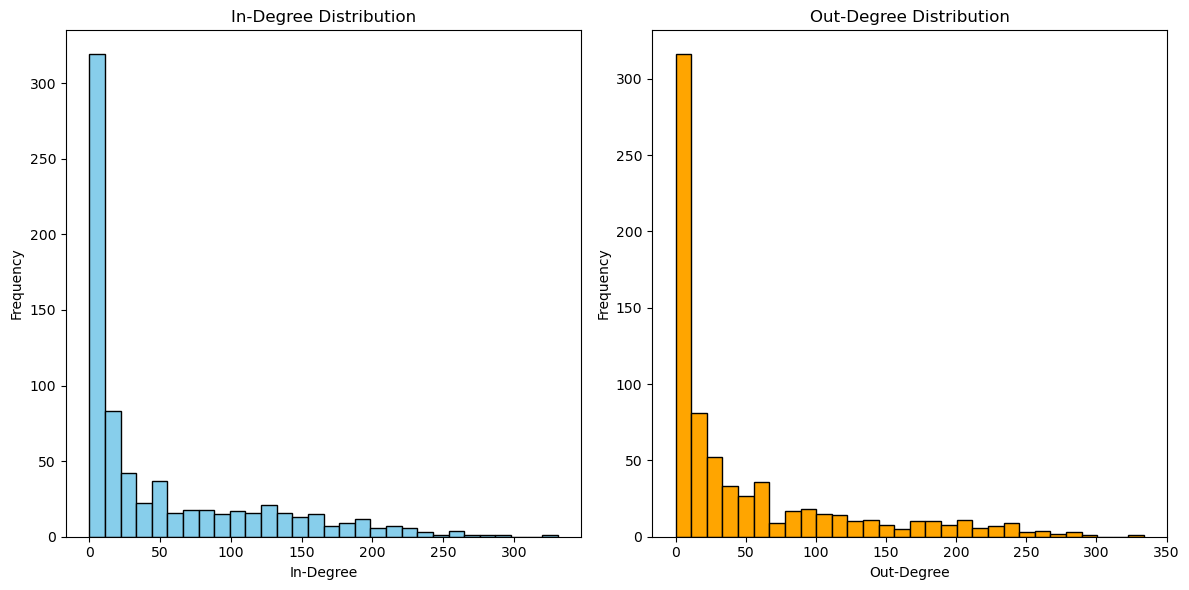

Graph Summary Report:
Number of airports (nodes): 727
Number of flights (edges): 36719
Graph Density: 0.1391
Graph Type: Dense

Identified Hubs (Airports with high degree):
   Node  In-Degree  Out-Degree  Total Degree
0   OKC        241         238           479
1   STL        257         264           521
2   SHV        257         203           460
3   OMA        186         208           394
4   MCO        195         223           418
..  ...        ...         ...           ...
73  PIA        164         139           303
74  BNA        221         220           441
75  RNO        159         185           344
76  ABQ        181         196           377
77  SAN        143         196           339

[78 rows x 4 columns]


In [13]:
summarize.summarize_graph_features(flight_network)

### 1.3 Deeper analysis

In [14]:
total_passengers = (df.groupby(['Origin_city', 'Destination_city'])['Passengers'].sum()
                    .reset_index().rename(columns={"Passengers": "Total_passengers"}))
total_passengers_df = total_passengers[['Origin_city', 'Destination_city', 'Total_passengers']]

In [15]:
total_passengers_df

,Origin_city,Destination_city,Total_passengers
0,"Aberdeen, SD","Anchorage, AK",2
1,"Aberdeen, SD","Billings, MT",100
2,"Aberdeen, SD","Bismarck, ND",67
3,"Aberdeen, SD","Brainerd, MN",32
4,"Aberdeen, SD","Eau Claire, WI",32
...,...,...,...
30326,"Yuma, AZ","Yuma, AZ",0
30327,"Zanesville, OH","Atlanta, GA",0
30328,"Zanesville, OH","Detroit, MI",0
30329,"Zanesville, OH","Kansas City, MO",0


In [16]:
# Sorting to find busiest routes by passengers flow
busiest_routes = total_passengers.sort_values(by='Total_passengers', ascending=False)
busiest_routes = busiest_routes.head(20)

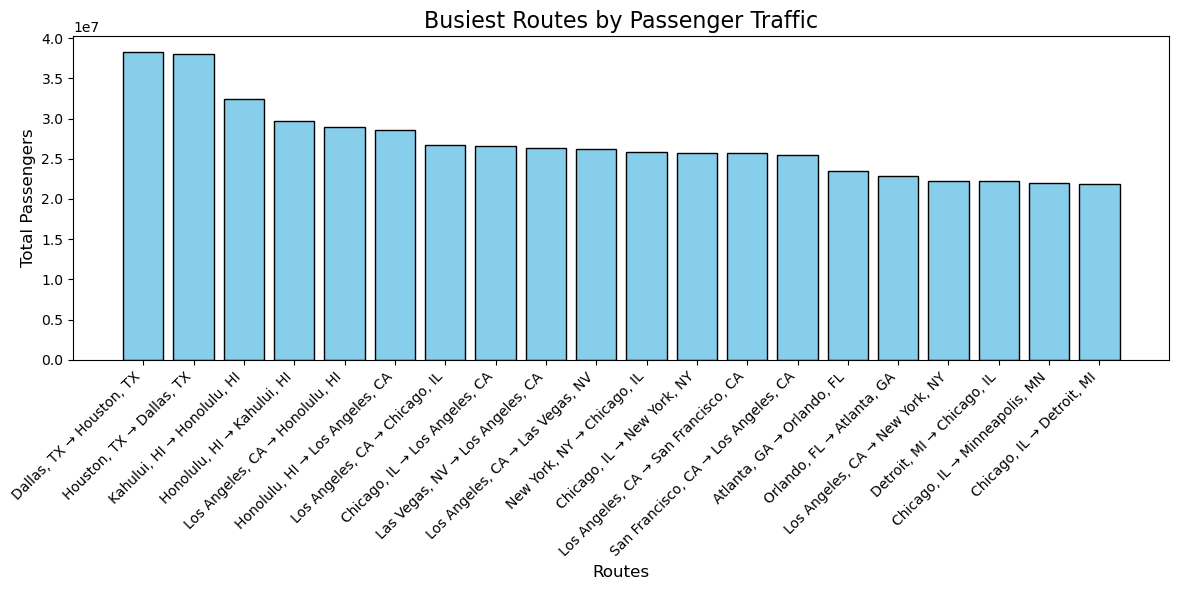

In [ ]:
visualization.visualize_busiest_routes(busiest_routes)

In [22]:
# Calculate the average passengers per flight for each route and highlight under/over-utilized connections.

# Add Total_flights column
total_flights_df = (
    df.groupby(["Origin_city", "Destination_city"])["Flights"]
    .sum()
    .reset_index()
    .rename(columns={"Flights": "Total_flights"})
)
total_flights_df = total_flights_df[['Origin_city', 'Destination_city', 'Total_flights']]

# Merge the two DataFrames
route_stats = pd.merge(total_passengers_df, total_flights_df, on=["Origin_city", "Destination_city"])

# Avoid division by 0 and null values and calculate the average passengers per flight
route_stats["Avg_pass_per_flight"] = np.where(
    (route_stats["Total_flights"] > 0) & (route_stats['Total_passengers'] > 0),
    (route_stats["Total_passengers"] / route_stats["Total_flights"]),
    0  
)

# Display the results
route_stats


,Origin_city,Destination_city,Total_passengers,Total_flights,Avg_pass_per_flight
0,"Aberdeen, SD","Anchorage, AK",2,1,2.0
1,"Aberdeen, SD","Billings, MT",100,1,100.0
2,"Aberdeen, SD","Bismarck, ND",67,2,33.5
3,"Aberdeen, SD","Brainerd, MN",32,1,32.0
4,"Aberdeen, SD","Eau Claire, WI",32,1,32.0
...,...,...,...,...,...
30326,"Yuma, AZ","Yuma, AZ",0,2,0.0
30327,"Zanesville, OH","Atlanta, GA",0,5,0.0
30328,"Zanesville, OH","Detroit, MI",0,3,0.0
30329,"Zanesville, OH","Kansas City, MO",0,1,0.0


In [23]:
# Define thresholds for under-utilized and over-utilized connections
under_utilized_threshold = route_stats["Avg_pass_per_flight"].quantile(0.3)
over_utilized_threshold = route_stats["Avg_pass_per_flight"].quantile(0.7)

# Highlight under-utilized and over-utilized connections
route_stats["Utilization"] = pd.cut(
    route_stats["Avg_pass_per_flight"],
    bins=[-float("inf"), under_utilized_threshold, over_utilized_threshold, float("inf")],
    labels=["Under-Utilized", "Moderately Utilized", "Over-Utilized"]
)
route_stats

,Origin_city,Destination_city,Total_passengers,Total_flights,Avg_pass_per_flight,Utilization
0,"Aberdeen, SD","Anchorage, AK",2,1,2.0,Under-Utilized
1,"Aberdeen, SD","Billings, MT",100,1,100.0,Over-Utilized
2,"Aberdeen, SD","Bismarck, ND",67,2,33.5,Moderately Utilized
3,"Aberdeen, SD","Brainerd, MN",32,1,32.0,Moderately Utilized
4,"Aberdeen, SD","Eau Claire, WI",32,1,32.0,Moderately Utilized
...,...,...,...,...,...,...
30326,"Yuma, AZ","Yuma, AZ",0,2,0.0,Under-Utilized
30327,"Zanesville, OH","Atlanta, GA",0,5,0.0,Under-Utilized
30328,"Zanesville, OH","Detroit, MI",0,3,0.0,Under-Utilized
30329,"Zanesville, OH","Kansas City, MO",0,1,0.0,Under-Utilized


In [35]:
'''
Creates an interactive map visualizing the geographic spread of the flight network.

Parameters:
- dataframe 
- output_file: Name of the file to save the generated map.

Returns:
- a map
'''
def create_interactive_map(flight_data, output_file='flight_network_map.html'):
    # Initialize the map with a central location on USA
    m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

    # Aggregate flight data to reduce redundancy
    aggregated_routes = (
        flight_data.groupby(['Origin_airport', 'Destination_airport'])
        .agg({
            'Org_airport_lat': 'first',
            'Org_airport_long': 'first',
            'Dest_airport_lat': 'first',
            'Dest_airport_long': 'first',
            'Passengers': 'sum' 
        })
        .reset_index()
    )

    # Add markers for unique airports
    unique_airports = flight_data[['Origin_airport', 'Org_airport_lat', 'Org_airport_long']].drop_duplicates()

    for _, row in unique_airports.iterrows():
        folium.CircleMarker(
            location=[row['Org_airport_lat'], row['Org_airport_long']],
            radius=3,
            color='blue',
            fill=True,
            fill_opacity=0.6,
            popup=f"Airport: {row['Origin_airport']}"
        ).add_to(m)

    # Add flight routes as polylines
    for _, row in aggregated_routes.iterrows():
        folium.PolyLine(
            locations=[
                [row['Org_airport_lat'], row['Org_airport_long']],
                [row['Dest_airport_lat'], row['Dest_airport_long']]
            ],
            color='blue',
            # Dynamic line thickness
            weight=min(5, 1 + row['Passengers'] / 1000), 
            opacity=0.5
        ).add_to(m)

    # Save the map to an HTML file
    m.save(output_file)
    print(f"Map saved to {output_file}")

    return m


In [32]:
create_interactive_map(df)

Map saved to flight_network_map.html


### 1.4 Summary Report
This section presents the final results in a tidy and clear format, summarizing key insights derived from the analysis:

- **Degree Distribution Plots**:
  - **In-Degree Distribution**: Visual representation of the distribution of incoming connections.
  - **Out-Degree Distribution**: Visual representation of the distribution of outgoing connections.
- **Number of Nodes and Edges**: A quantitative overview of the graph structure.
- **Graph Density**: A measure of how densely the graph is connected.
- **Identified Hubs**: A table highlighting the most connected or influential nodes in the network.
- **Top Routes by Passenger Flow**:
  - A table listing routes with the highest passenger flow.
  - A bar chart visualizing these top routes.
- **Top Routes by Passenger Efficiency**:
  - A table listing routes optimized for passenger efficiency.
  - A bar chart visualizing these top routes.
- **Interactive Map of Flight Routes**: A dynamic map showcasing the flight routes with geospatial context.

This report aims to provide a comprehensive summary of the data and key findings for further insights and decision-making.


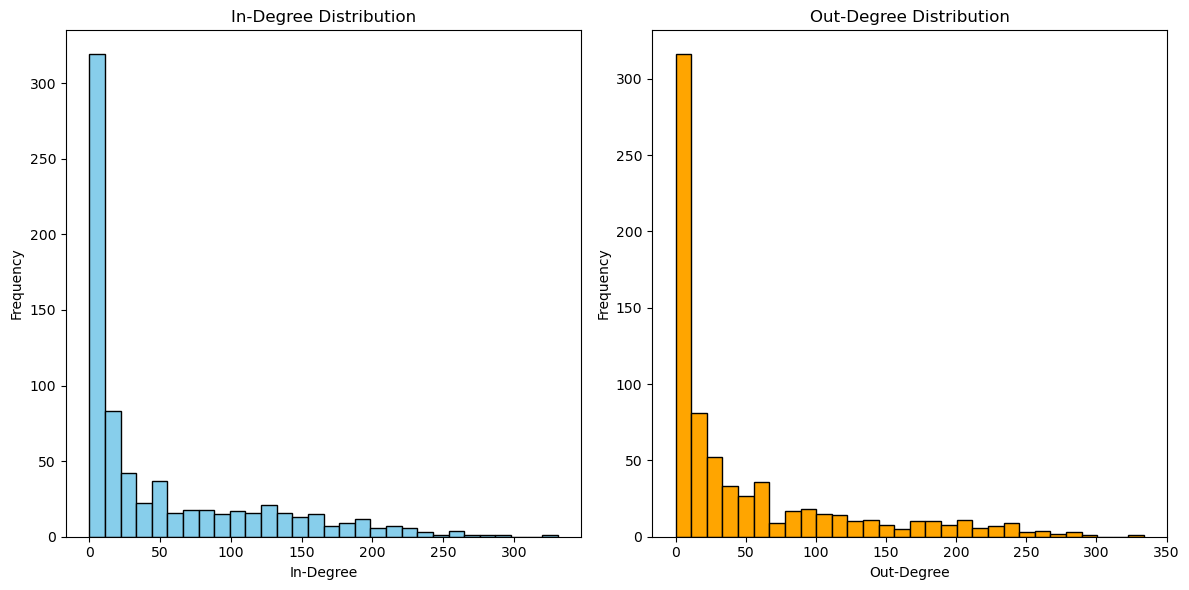

Graph Summary Report:
Number of airports (nodes): 727
Number of flights (edges): 36719
Graph Density: 0.1391
Graph Type: Dense

Identified Hubs (Airports with high degree):
   Node  In-Degree  Out-Degree  Total Degree
0   OKC        241         238           479
1   STL        257         264           521
2   SHV        257         203           460
3   OMA        186         208           394
4   MCO        195         223           418
..  ...        ...         ...           ...
73  PIA        164         139           303
74  BNA        221         220           441
75  RNO        159         185           344
76  ABQ        181         196           377
77  SAN        143         196           339

[78 rows x 4 columns]


In [17]:
# Return the degree distribution plots, number of nodes and edges, graph density, and a table of the identified hubs
summarize.summarize_graph_features(flight_network)

In [18]:
# Table of the top 20 busiest routes
busiest_routes

,Origin_city,Destination_city,Total_passengers
7122,"Dallas, TX","Houston, TX",38294810
12391,"Houston, TX","Dallas, TX",37989016
13585,"Kahului, HI","Honolulu, HI",32364664
12259,"Honolulu, HI","Kahului, HI",29744742
16133,"Los Angeles, CA","Honolulu, HI",28963623
12264,"Honolulu, HI","Los Angeles, CA",28631618
16083,"Los Angeles, CA","Chicago, IL",26751937
5323,"Chicago, IL","Los Angeles, CA",26645060
15218,"Las Vegas, NV","Los Angeles, CA",26333721
16152,"Los Angeles, CA","Las Vegas, NV",26177809


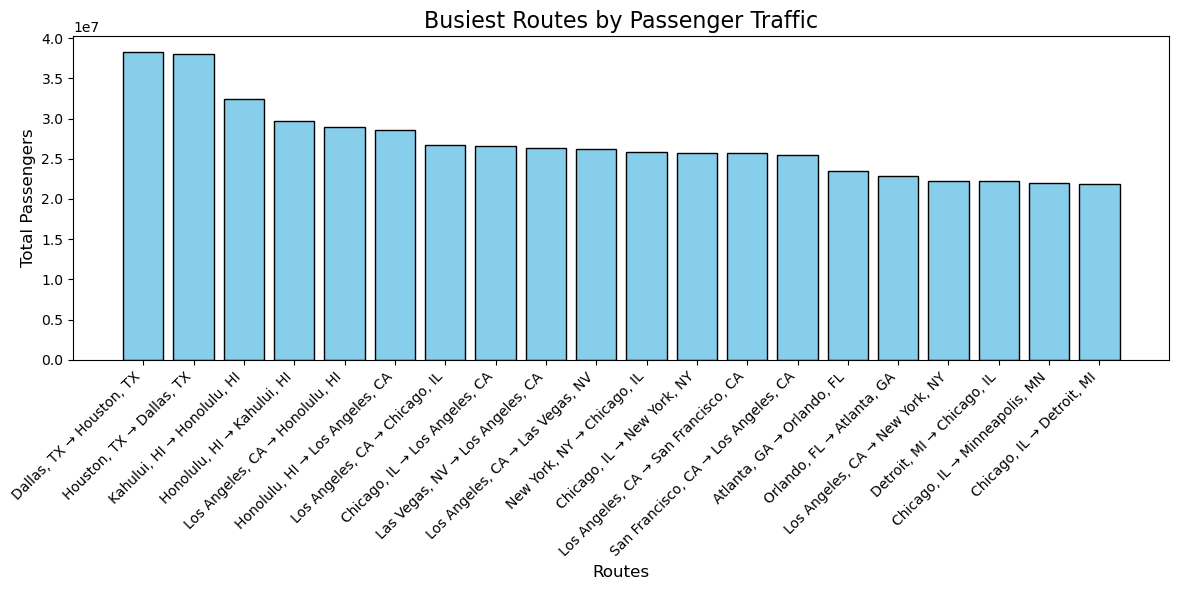

In [21]:
# Visualize the busiest routes by chart
visualization.visualize_busiest_routes(busiest_routes)

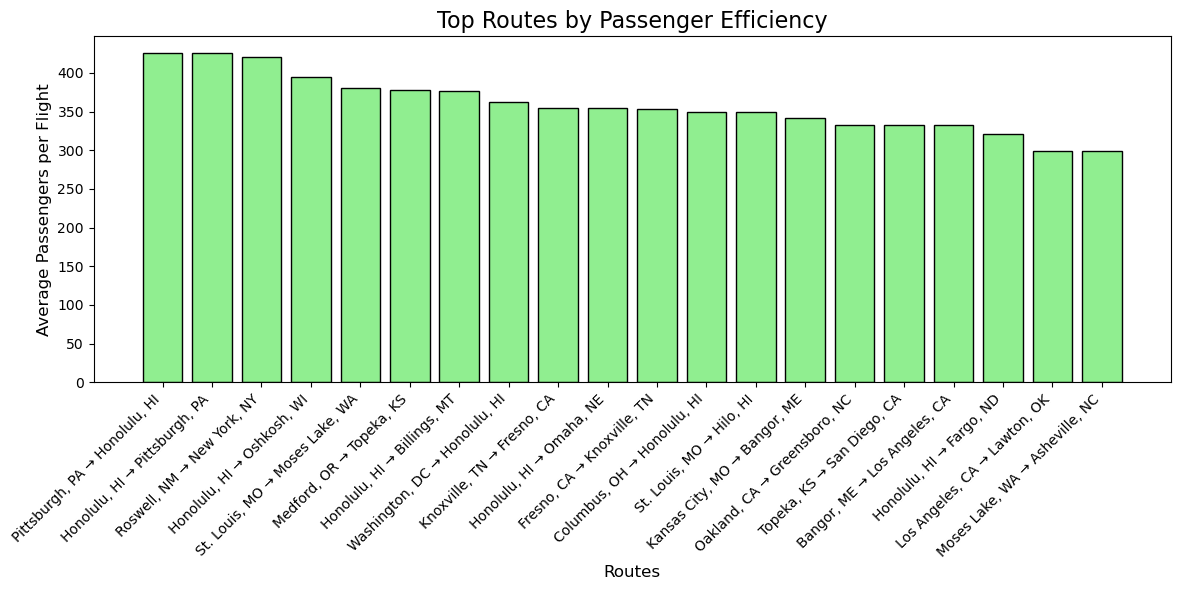

,Origin_city,Destination_city,Total_passengers,Total_flights,Avg_pass_per_flight,Utilization
21693,"Pittsburgh, PA","Honolulu, HI",426,1,426.000000,Over-Utilized
12284,"Honolulu, HI","Pittsburgh, PA",426,1,426.000000,Over-Utilized
23844,"Roswell, NM","New York, NY",421,1,421.000000,Over-Utilized
12281,"Honolulu, HI","Oshkosh, WI",395,1,395.000000,Over-Utilized
26996,"St. Louis, MO","Moses Lake, WA",380,1,380.000000,Over-Utilized
17005,"Medford, OR","Topeka, KS",378,1,378.000000,Over-Utilized
12225,"Honolulu, HI","Billings, MT",377,1,377.000000,Over-Utilized
29084,"Washington, DC","Honolulu, HI",362,1,362.000000,Over-Utilized
14288,"Knoxville, TN","Fresno, CA",355,1,355.000000,Over-Utilized
12279,"Honolulu, HI","Omaha, NE",1063,3,354.333333,Over-Utilized


In [ ]:
# Shows top 20 flights by passengers efficiency using chart and table
visualization.top_routes_by_efficiency(route_stats, top_n=20)

In [ ]:
# visualize the map ---> go to readme.md to see it 
#create_interactive_map(df)

### 1.5 Questions to address

1. Is the graph sparse or dense?

    The graph is dense

2. What patterns do you observe in the degree distribution?
    1. *Right-Skewed Distributions*: Most nodes have low in-degree/out-degree, with few highly connected hubs.
    2. *Hubs*: A small number of nodes dominate the network, acting as central hubs.
    3. *Asymmetry*: In-degree has a wider range than out-degree.
    4. *Sparsity*: Many nodes have minimal connectivity, indicating a sparse graph.

    Interpretation:
    - *Efficient Design*: Reflects efficient traffic concentration around key hubs.

3. Which airports are identified as hubs, and why?

    Airports with high in-degree and/or high out-degree are identified as hubs because these airports serve as central connecting points in the network, handling high traffic volume or acting as transfer points for passengers. The top 5 hubs are: OKC, STL, SHV, OMA, MCO

4. What are the busiest routes in terms of passenger traffic?

    The top 5 busiest routes in terms of passenger traffic are:
    - Dallas, TX	Houston, TX	
    - Houston, TX	Dallas, TX	
    - Kahului, HI	Honolulu, HI	
    - Honolulu, HI	Kahului, HI	
    - Los Angeles, CA	Honolulu, HI

5. Which routes are under/over-utilized?

    The top 5 over-utilized routes are:
    - Pittsburgh, PA	Honolulu, HI
    - Honolulu, HI	Pittsburgh, PA	
    - Roswell, NM	New York, NY
    - Honolulu, HI	Oshkosh, WI
    - St. Louis, MO	Moses Lake, WA

    The top 5 under-utilized routes are:
    - Yuma, AZ	Yuma, AZ
    - Zanesville, OH	Atlanta, GA
    - Zanesville, OH	Detroit, MI
    - Zanesville, OH	Kansas City, MO
    - Zanesville, OH	Shreveport, LA	

## **2. Nodes' Contribution (Q2)**

*In any network, certain nodes (airports, in this case) play a critical role in maintaining connectivity and flow. Centrality measures are used to identify these nodes.*

**Your Task:**
Implement a function analyze_centrality(flight_network, airport) that computes the following centrality measures for a given airport:

- Betweenness centrality: Measures how often a node appears on the shortest paths between other nodes.
- Closeness centrality: Measures how easily a node can access all other nodes in the network.
- Degree centrality: Simply counts the number of direct connections to the node.
- PageRank: Computes the "importance" of a node based on incoming connections and their weights.

Write a function compare_centralities(flight_network) to:

- Compute and compare centrality values for all nodes in the graph.
- Plot centrality distributions (histograms for each centrality measure).
- Return the top 5 airports for each centrality measure.
- Ask LLM (eg. ChatGPT) to suggest alternative centrality measures that might be relevant to this task. How can you check that the results given by the LLM are trustable?

Implement one of these measures suggested by the LLM, compare its results to the centralities you've already computed, and analyze whether it adds any new insights.

### Analysis of Centrality Measures

In this section, we will analyze the flight network using different centrality measures to identify the most critical airports. We will explore the following centrality measures:
- **Betweenness Centrality**
- **Closeness Centrality**
- **Degree Centrality**
- **PageRank**

We will also experiment with an additional centrality measure suggested by a Large Language Model (LLM) and discuss how to verify the trustworthiness of the LLM's recommendations.

In [12]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict, deque

# Display plots inline (if using classic Jupyter)
%matplotlib inline

In [13]:
from funtions2.function2 import  (
    calculate_degree_centrality,
    calculate_closeness_centrality,
    bfs_shortest_paths,
    calculate_betweenness_centrality,
    calculate_shortest_path_dependencies,
    count_paths_through_node,
    calculate_page_rank,
    analyze_centrality,
    compare_centralities
)

## Data Loading and Network Construction

Below, we load our flight data and create a directed graph using NetworkX. 

In [16]:
# Example: load flight data from a CSV
# You will need to adapt this for your actual file path and columns
# Suppose the CSV has columns ['source_airport', 'destination_airport']

flight_data = df  # Adapt the path

# Create a directed graph
flight_network = nx.DiGraph()

# Populate the graph
for idx, row in flight_data.iterrows():
    source = row['Origin_airport']
    destination = row['Destination_airport']
    # Add edge with a weight or frequency if available
    flight_network.add_edge(source, destination)

### **Explanation of Centrality Measures**

1. **Betweenness Centrality**  
2. **Closeness Centrality**  
3. **Degree Centrality**  
4. **PageRank** (not detailed below, but also widely used)

### Betweenness Centrality

### Definition

Betweenness centrality measures how often a node lies on the shortest paths between other nodes in a graph. It quantifies the importance of a node in controlling communication or flow within a network.

### Mathematical Formula

For a node $ v $, betweenness centrality is given by:

$$
C_B(v) \;=\; \sum_{s \neq v \neq t} \; \frac{\sigma_{s,t}(v)}{\sigma_{s,t}}
$$

Where:
- $ \sigma_{s,t} $ is the total number of shortest paths from node $ s $ to node $ t $.
- $ \sigma_{s,t}(v) $ is the number of those shortest paths that pass through $ v $.

### Steps to Compute Betweenness Centrality
1. **Identify all shortest paths**: For each pair of nodes $ s $ and $ t $ in the network, compute the shortest paths between them.
2. **Count path usage**: Determine how many of these shortest paths pass through the node $ v $.
3. **Sum fractions**: For all pairs $(s, t)$, add up the fraction $\frac{\sigma_{s,t}(v)}{\sigma_{s,t}}$. This yields the betweenness centrality of $ v $.


In [36]:
help(compute_betweenness_for_node)

Help on function brandes_betweenness_all_nodes in module funtions2.function2:

brandes_betweenness_all_nodes(graph)
    Use Brandes' algorithm to compute betweenness centrality for every node in a directed,
    unweighted graph. Returns a dict {node: betweenness_value}.
    
    The Betweenness Centrality of a node v is roughly how many shortest paths between other pairs
    (s, t) pass through v. Brandes' method does BFS from each node and back-propagates dependencies.

Help on function compute_betweenness_for_node in module funtions2.function2:

compute_betweenness_for_node(graph, airport)
    Compute Brandes betweenness centrality for all nodes, then return it
    for the single specified 'airport'.



### **Degree Centrality**

##### *Definition*

Degree centrality is the simplest centrality measure: it counts the number of direct connections (edges) a node has to other nodes in the network.

##### *Mathematical Formula*

For a node $ v $, degree centrality is:

$$
C_D(v) \;=\; \mathrm{degree}(v)
$$

Where:
- $\mathrm{degree}(v)$ is the number of edges connected to node $v$.

In a **directed** network, one often considers two types of degrees:
- **In-degree**: Number of edges (connections) pointing *into* $ v $.
- **Out-degree**: Number of edges (connections) going *out of* $ v $.

##### *Steps to Compute Degree Centrality*
1. **Count neighbors**: For undirected networks, simply count the edges of $ v $.  
2. **Directed case**: For directed networks, the degree can be split into in-degree and out-degree, or summed to get the total degree (in + out).

---


In [ ]:
help(compute_degree_centrality)

Help on function compute_degree_centrality in module funtions2.function2:

compute_degree_centrality(graph, airport)
    Compute the degree centrality for a single 'airport'.
    
    Degree Centrality(airport) = in_degree(airport) + out_degree(airport)
    
    - out_degree(airport) is simply the length of graph[airport].
    - in_degree(airport) is the number of adjacency lists that include 'airport'.



### **Closeness Centrality**

#####  *Definition*

Closeness centrality measures how "close" a node is to all other nodes in the network. It is based on the total distance from the node to every other node.

##### *Mathematical Formula*

For a node $ v $, closeness centrality is often defined as the reciprocal of the sum of shortest path distances from $ v $ to all other nodes:

$$
C_C(v) \;=\; \frac{1}{\sum_{u \in V} d(v, u)}
$$

Where:
- $ d(v, u) $ is the shortest path distance from node $ v $ to node $ u $.
- $ V $ is the set of all nodes in the graph.

##### *Steps to Compute Closeness Centrality*
1. **Compute distances**: For a given node $ v $, compute the shortest distance to every other node $u$.
2. **Sum distances**: Add these distances up into a total $ \sum_{u} d(v, u) $.
3. **Take the reciprocal**: Closeness centrality is $ 1 \;/\; \text{(total distances)} $. A smaller sum of distances yields a larger closeness score, meaning the node is more central.


In [ ]:
help(compute_closeness_centrality)

Help on function compute_closeness_centrality in module funtions2.function2:

compute_closeness_centrality(graph, airport)
    Closeness Centrality(airport) = (# reachable nodes) / (sum of distances to reachable nodes).
    
    - We first do a BFS to get the distance from 'airport' to every other node.
    - We ignore any node that is unreachable (distance = inf).
    - If no nodes are reachable, closeness is 0.



### **Explanation of PageRank**


### **Definition**

PageRank is a centrality measure that assigns a score to each node in a directed graph, representing the importance of the node based on the structure of incoming and outgoing edges. It was originally developed to rank web pages in Google's search engine.

PageRank assumes that a link (edge) from one node to another is a vote of importance, and nodes that receive many links from important nodes are themselves considered important.



### **Mathematical Formula**

PageRank is calculated iteratively using the following formula:

$$
PR(v) = \frac{1 - \alpha}{N} + \alpha \sum_{u \in \text{In}(v)} \frac{PR(u)}{\text{OutDeg}(u)}
$$

Where:
- $ PR(v) $: PageRank of node $ v $.
- $ \alpha $: Damping factor (usually set to 0.85).
- $ N $: Total number of nodes in the graph.
- $ \text{In}(v) $: Set of nodes that have an edge pointing to $ v $.
- $ \text{OutDeg}(u) $: Out-degree of node $ u $ (number of edges leaving $ u $).
- $ \frac{1 - \alpha}{N} $: Teleportation term, which ensures that the algorithm does not get stuck in disconnected parts of the graph.


### **Steps to Compute PageRank**

1. **Initialization**:  
   - Assign an equal initial PageRank score to all nodes:  
     $$
     PR(v) = \frac{1}{N}, \quad \forall v \in V
     $$

2. **Iterative Update**:  
   - Recalculate the PageRank of each node $ v $ based on the formula:
     $$
     PR(v) = \frac{1 - \alpha}{N} + \alpha \sum_{u \in \text{In}(v)} \frac{PR(u)}{\text{OutDeg}(u)}
     $$

3. **Teleportation**:  
   - Add the teleportation term $ \frac{1 - \alpha}{N} $ to prevent dangling nodes (nodes with no outgoing edges) from affecting the calculation.

4. **Convergence**:  
   - Repeat the calculation until the change in PageRank scores between iterations is less than a specified threshold ($ tol $) or until the maximum number of iterations ($ max\_iter $) is reached.



### **Key Concepts**

- **Damping Factor ($ \alpha $)**:  
  - The damping factor represents the probability that a "random surfer" follows an outgoing edge from a node. With probability $ 1 - \alpha $, the surfer teleports to a random node.
  - A typical value for $ \alpha $ is 0.85.

- **Dangling Nodes**:  
  - Nodes with no outgoing edges can distort the calculation. PageRank handles this by redistributing their rank equally among all nodes or using the teleportation mechanism.

- **Convergence**:  
  - The algorithm iteratively updates the PageRank scores until they stabilize. Convergence is achieved when the difference between scores in successive iterations is below a predefined threshold.



### **Practical Applications**

- **Web Search**:  
  - PageRank was originally used to rank web pages based on the importance of incoming links.

- **Social Networks**:  
  - Identify influential nodes in social or communication networks.

- **Transportation Networks**:  
  - Analyze the importance of airports or cities based on connectivity and flow.

- **Recommendation Systems**:  
  - Rank items or users based on interaction graphs.

By understanding and applying PageRank, you can effectively analyze the importance of nodes in a wide range of networks.

---

### **References**

1. Page, L., Brin, S., Motwani, R., & Winograd, T. (1999). *The PageRank Citation Ranking: Bringing Order to the Web*. Stanford InfoLab.  
   [Available Here](http://ilpubs.stanford.edu:8090/422/)

2. Langville, A. N., & Meyer, C. D. (2012). *Google's PageRank and Beyond: The Science of Search Engine Rankings*. Princeton University Press.

3. Kleinberg, J. (1999). *Authoritative sources in a hyperlinked environment*. Journal of the ACM, 46(5), 604–632.

4. Newman, M. E. J. (2010). *Networks: An Introduction*. Oxford University Press.


In [ ]:
help(compute_pagerank_all)
help(compute_pagerank_for_node)

Help on function compute_pagerank_all in module funtions2.function2:

compute_pagerank_all(graph, alpha=0.85, max_iter=100, tol=1e-06)
    Calculate PageRank for all nodes in a directed, unweighted graph.
    - alpha: damping factor (0.85 is typical).
    - max_iter: max number of power-iteration steps.
    - tol: minimum difference threshold for convergence.
    Returns a dict {node: pagerank_value}.

Help on function compute_pagerank_for_node in module funtions2.function2:

compute_pagerank_for_node(graph, airport)
    Compute PageRank for all nodes, then return the value for the given 'airport'.



## Analyze Centrality for a Single Airport

Let's compute the various centrality measures for one specific airport as an example.

In [17]:
# Pick an airport (replace 'JFK' with an actual airport in your dataset)
airport_to_test = 'JFK'
centralities_single = analyze_centrality(flight_network, airport_to_test)
centralities_single

{'Airport': 'JFK',
 'Degree Centrality': 0.2940771349862259,
 'Closeness Centrality': 0.5857497928748965,
 'Betweenness Centrality': 0.2299078559893607,
 'PageRank': 0.0047870715393614855}

## Compare Centralities Across All Airports

Now, let's compute and compare these measures across the entire network.
We will also plot their distributions and identify the top 5 airports for each measure.

Calculating Centralities: 100%|██████████| 727/727 [44:28<00:00,  3.67s/it]


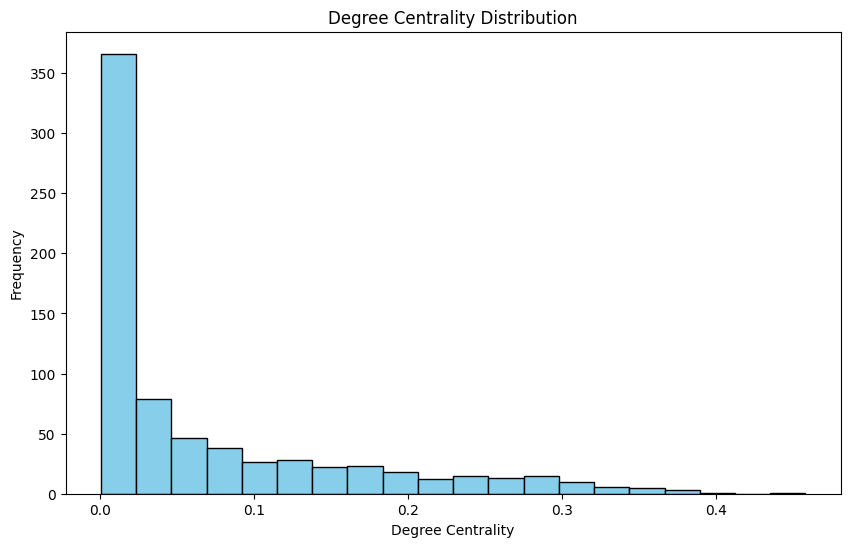

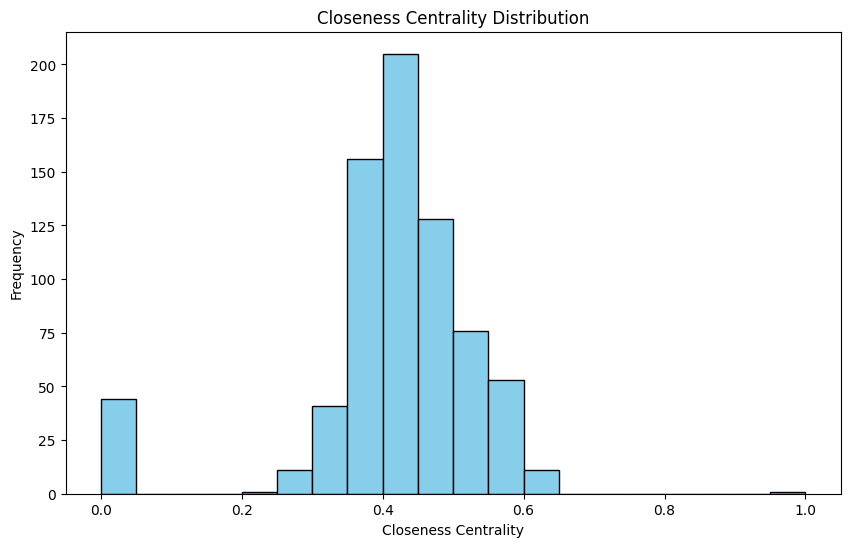

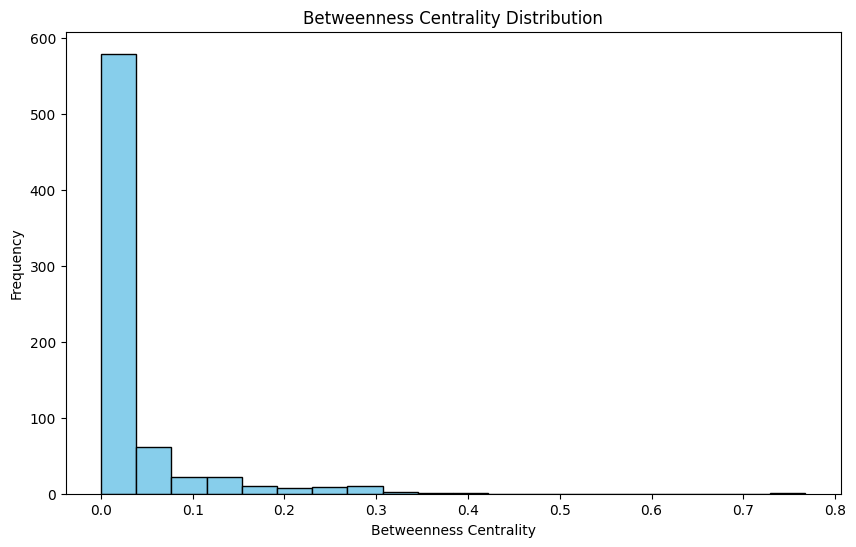

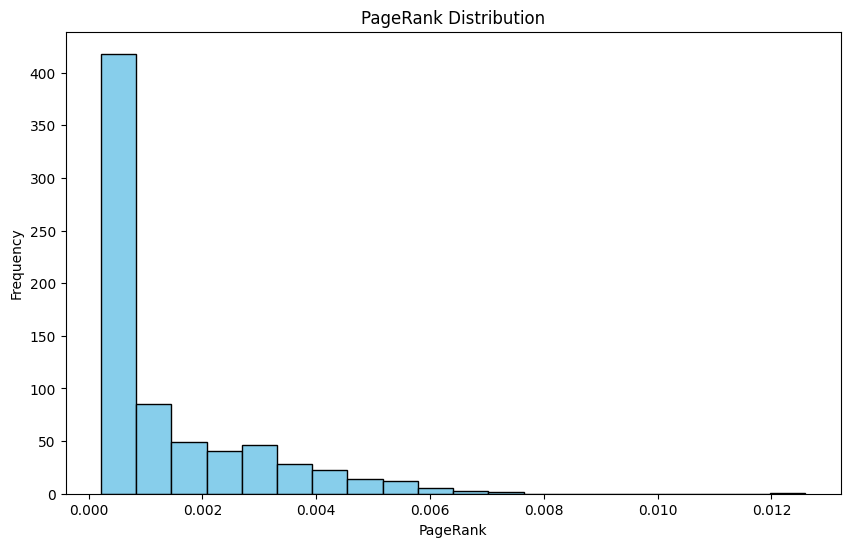

{'top_degree': [['YIP', 0.45798898071625344],
  ['MSP', 0.4015151515151515],
  ['MEM', 0.3884297520661157],
  ['MCI', 0.3712121212121212],
  ['ATL', 0.3712121212121212]],
 'top_closeness': [['FVS', 1.0],
  ['YIP', 0.643312101910828],
  ['MSP', 0.6229074889867842],
  ['MEM', 0.6190893169877408],
  ['ORD', 0.6185476815398075]],
 'top_betweenness': [['YIP', 0.7676223045502042],
  ['MSP', 0.3985636933599316],
  ['SHV', 0.3686843355181913],
  ['MCI', 0.3453443526170799],
  ['MEM', 0.33691840030398024]],
 'top_pagerank': [['YIP', 0.012596739235285695],
  ['SHV', 0.0075766713087627195],
  ['MSP', 0.007489817524955051],
  ['MEM', 0.006988517029806561],
  ['MCI', 0.006970352425966445]]}

In [18]:
results = compare_centralities(flight_network)
results

### Querying an LLM for Additional Centrality Measures

We asked ChatGPT to suggest other centrality measures that could be relevant. 
For instance, ChatGPT might suggest:
- **Eigenvector Centrality**
- **Katz Centrality**
- **HITS (Hub/Authority)**

How do we verify these suggestions?
- **Check academic references**: e.g., look up known measures in standard textbooks or scientific publications.
- **Compare** with well-documented libraries (e.g., `networkx.algorithms.centrality`).
- **Test** them on small or known networks for sanity checks.

### Trustworthiness of LLM Results

To ensure the suggestions are trustable, we:
- Compare them against widely accepted measures documented in `networkx`.
- Validate definitions match known formulas.
- For any major decisions, confirm results with domain experts or well-known references (e.g., academic papers).

### Implementing Eigenvector Centrality

We will implement a simple wrapper around NetworkX's `nx.eigenvector_centrality` for demonstration.

In [19]:
def calculate_eigenvector_centrality(flight_network, max_iter=100, tol=1e-06):
    """
    Calculate Eigenvector Centrality for all nodes in the flight_network using NetworkX's built-in function.
    """
    return nx.eigenvector_centrality(flight_network, max_iter=max_iter, tol=tol)

# Calculate and compare
eigen_centrality_dict = calculate_eigenvector_centrality(flight_network)

# Turn into a DataFrame for easy comparison
eigen_df = pd.DataFrame({
    'Airport': list(eigen_centrality_dict.keys()),
    'EigenvectorCentrality': list(eigen_centrality_dict.values())
})

eigen_df.sort_values(by='EigenvectorCentrality', ascending=False).head(10)

,Airport,EigenvectorCentrality
104,MSP,0.106748
131,MEM,0.105694
136,IND,0.102812
128,STL,0.102692
183,ATL,0.102676
100,MCI,0.101431
196,YIP,0.099491
119,ORD,0.099218
33,DFW,0.098503
51,OKC,0.096784


### Analysis of Eigenvector Centrality

Here, we compare the top airports identified by Eigenvector Centrality with other measures. 
Does it add new insights into the most "influential" nodes in the network?

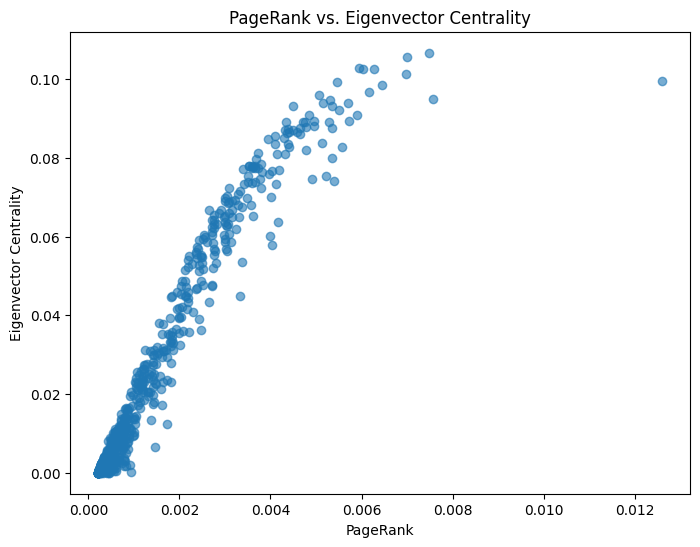

In [20]:
# For a quick correlation check with PageRank, for instance:
pagerank_values = []
eigen_values = []

for airport in flight_network.nodes():
    pagerank_values.append(calculate_page_rank(flight_network, airport))
    eigen_values.append(eigen_centrality_dict[airport])

# Create a simple scatter plot
plt.figure(figsize=(8,6))
plt.scatter(pagerank_values, eigen_values, alpha=0.6)
plt.title("PageRank vs. Eigenvector Centrality")
plt.xlabel("PageRank")
plt.ylabel("Eigenvector Centrality")
plt.show()

# Here are some info on the function used to check the distances 

In [38]:
help(analyze_centrality)
help(compare_centralities)

Help on function analyze_centrality in module funtions2.function2:

analyze_centrality(df, airport)
    Build the directed graph from 'df' using 'build_directed_graph'.
    Then compute the following for a single 'airport':
       - Degree Centrality
       - Closeness Centrality
       - Betweenness Centrality
       - PageRank
    Returns a dict with these 4 measures for 'airport'.

Help on function compare_centralities in module funtions2.function2:

compare_centralities(df)
    1) Build the directed flight graph from 'df'.
    2) Compute:
       - Degree (in+out)
       - Closeness (BFS)
       - Betweenness (Brandes)
       - PageRank (iterative)
       for ALL nodes in the graph.
    3) Plot each distribution as a histogram.
    4) Return the top-5 airports for each metric in a dictionary.



### FUNCTION TO CHECK EVENTUALY ANOMALIES ••

In [46]:
from funtions2.function2 import check_flight_data

In [47]:
help(check_flight_data)

Help on function check_flight_data in module funtions2.function2:

check_flight_data(df)
    Perform basic checks on the flight DataFrame:
      1) Check for fully duplicated rows.
      2) Identify any rows where Origin_airport == Destination_airport (self-loops).
      3) Check for missing (NaN) values in 'Origin_airport' or 'Destination_airport'.
      4) (Optional) Flag suspicious IATA codes based on their length (<3 or >4 characters).
    
    Returns:
        list of strings describing any problems found.



In [48]:
df_problems = check_flight_data(df)
if df_problems:
    print("=== PROBLEM IN DATAFRAME===")
    for p in df_problems:
        print(" -", p)
else:
    print("No problem in dataframe.")


=== PROBLEM IN DATAFRAME===
 - Found 6068 rows where Origin == Destination (self-loops).


## Calculation of Centralities and Checking for Outliers.
After calculating all centralities (Degree, Closeness, Betweenness, PageRank) for all nodes, let's check for any outliers:

Closeness = 1.0 (or > 0.9, your choice) is very rare in a real flight network.
Much higher than average values in Betweenness. E.g., if an airport exceeds the average by 3-4 standard deviations.
Ditto on PageRank (though here it rarely gets to 1.0, usually < 0.05 in large networks, but you might have outliers in small network).

Translated with DeepL.com (free version)

## Integration with compare_centralities.
After calculating the 4 centralities, we can do the check:

In [49]:
from funtions2.function2 import detect_centrality_anomalies, compare_centralities_with_checks, detect_centrality_anomalies

In [50]:
help(detect_centrality_anomalies)

Help on function detect_centrality_anomalies in module funtions2.function2:

detect_centrality_anomalies(degree_dict, closeness_dict, betweenness_dict, pagerank_dict)
    Examine the four centrality dictionaries and detect possible outliers.
    
    Returns a list of textual warnings for nodes that exceed certain thresholds, e.g.:
      - closeness >= 0.9999
      - betweenness / pagerank / degree > mean + 3*std



In [51]:
help(compare_centralities_with_checks)

Help on function compare_centralities_with_checks in module funtions2.function2:

compare_centralities_with_checks(df)
    Extended version of a typical "compare_centralities":
      - Build a directed graph from df.
      - Compute the four measures (Degree, Closeness, Betweenness, PageRank) for all nodes.
      - Plot their distributions in histograms.
      - Return the top-5 nodes for each measure.
      - Also run anomaly checks (detect_centrality_anomalies) to flag potential outliers.
    
    Returns a dictionary with:
      {
        "top_degree": [...],
        "top_closeness": [...],
        "top_betweenness": [...],
        "top_pagerank": [...],
        "anomalies": [list_of_anomalies]
      }



In [52]:
help(detect_centrality_anomalies)

Help on function detect_centrality_anomalies in module funtions2.function2:

detect_centrality_anomalies(degree_dict, closeness_dict, betweenness_dict, pagerank_dict)
    Examine the four centrality dictionaries and detect possible outliers.
    
    Returns a list of textual warnings for nodes that exceed certain thresholds, e.g.:
      - closeness >= 0.9999
      - betweenness / pagerank / degree > mean + 3*std



# 3. Finding Best Routes (Q3)
Whenever you plan to fly to a specific city, your goal is to find the most efficient and fastest flight to reach your destination. In the system you are designing, the best route is defined as the one that minimizes the total distance flown to the greatest extent possible.

In this task, you need to implement a function that, given an origin and destination city, determines the best possible route between them. To simplify, the focus will be limited to flights operating on a specific day.
Note: Each city may have multiple airports; in such cases, the function should calculate the best route for every possible airport pair between the two cities. For example, if city 
A
 has airports 
a
1
,
a
2
 and city B has 
b
1
,
b
2
, the function should compute the best routes for 
a
1
→
b
1
, 
a
1
→
b
2
, 
a
2
→
b
1
 and 
a
2
→
b
2
. If it’s not possible to travel from one airport in the origin city to another airport in the destination city on that date, you must report it as well.

The function takes the following inputs:

Flights network
Origin city name
Destination city name
Considered Date (in yyyy-mm-dd format)
The function output:

A table with three columns: 'Origin_city_airport', 'Destination_city_airport', and the 'Best_route'.
Note: In the "Best_route" column, we expect a list of airport names connected by 
→
, showing the order in which they are to be visited during the optimal route. If no such route exists, the entry should display "No route found."



In [1]:
import pandas as pd
df = pd.read_csv('FinalDatasetForReal.csv')

In [2]:
df = df.drop(['Unnamed: 0'], axis=1)

In [3]:
df.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,41.990311,-93.622154
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


In [127]:
from part5_func import Graph_weights # same function we used for number 5 but with Weighted Edges and Directed Support


# Extract edges (origin, destination, weight) from the dataset
edges = [
    (row['Origin_airport'], row['Destination_airport'], row['Distance'])
    for _, row in df.iterrows()
    if not pd.isnull(row['Distance'])  # Ensure the distance is not null
]

airport_graph_w = Graph_weights(edges=edges, directed=True) # Initializzation

# Print graph properties for verification
print(f"Number of nodes (airports): {len(airport_graph_w.nodes)}")
print(f"Number of edges (flights): {len(airport_graph_w.weights)}")

# Display a sample of edges with weights
print("Sample Edges with Weights:")
for edge, weight in list(airport_graph_w.weights.items())[:5]:
    print(f"{edge}: Distance = {weight}")


Number of nodes (airports): 727
Number of edges (flights): 36719
Sample Edges with Weights:
('MHK', 'AMW'): Distance = 254
('EUG', 'RDM'): Distance = 103
('MFR', 'RDM'): Distance = 156
('SEA', 'RDM'): Distance = 228
('PDX', 'RDM'): Distance = 116


While Checking the first functions of the algorithm I noticied a mistake: some nodes appears as neighbor in graph adjacency list but is missing from distances dictionary while calculating betweeness centrality; it return this error:

```
Cell In[21], line 55
     52 weight = weights.get((current_node, neighbor), float('inf'))  # Use weight from dictionary
     53 distance = current_distance + weight
---> 55 if distance < distances[neighbor]:
     56     distances[neighbor] = distance
     57     previous_nodes[neighbor] = current_node

KeyError: 'ULS'
```

In [26]:
# Validate graph consistency
dangling_nodes = set()

for node, neighbors in airport_graph_w.graph.items():
    for neighbor in neighbors:
        if neighbor not in airport_graph_w.graph:
            dangling_nodes.add(neighbor)

if dangling_nodes:
    print(f"[ERROR] Dangling nodes detected in the graph: {dangling_nodes}")
else:
    print("[DEBUG] Graph integrity verified. No dangling nodes found.")


[ERROR] Dangling nodes detected in the graph: {'MUT', 'RAC', 'CFV', 'MWC', 'NGP', 'UXJ', 'WVL', 'LJY', 'MEJ', 'DWH', 'FCM', 'TVI', 'IDI', 'AYS', 'SME', 'DTN', 'OGB', 'ESN', 'TDW', 'HUA', 'STK', 'NZJ', 'OLU', 'O85', 'JWN', 'FAM', 'MPS', 'SNL', 'RSN', 'RBL', 'PRZ', 'SNS', 'RVS', 'AWX', 'JCC', 'STE', 'XWL', 'ZXX', 'ULS', 'PHD', 'ARB', 'AL3', 'BYI'}


This confirms our hypothesis above, next step:
- Removed neighbors that don't exist in the graph
- Remove Orphan Node
- Removed edge weights associated with invalid nodes

In [27]:
def remove_dangling_nodes(graph, weights):
    """
    Remove dangling nodes from the graph and ensure all edges have valid references.

    Args:
        graph (dict): Adjacency list representation of the graph.
        weights (dict): Dictionary with edge weights.

    Returns:
        tuple: (cleaned_graph, cleaned_weights)
    """
    valid_nodes = set(graph.keys())  # Nodes present in the graph

    # Validate neighbors in the adjacency list
    for node in list(graph.keys()):
        graph[node] = {neighbor for neighbor in graph[node] if neighbor in valid_nodes}
        
        # If the node has no valid neighbors, remove it
        if not graph[node]:
            del graph[node]

    # Validate weights
    cleaned_weights = {
        (u, v): w for (u, v), w in weights.items()
        if u in graph and v in graph[u]
    }

    return graph, cleaned_weights


# Clean the graph and weights
airport_graph_w.graph, airport_graph_w.weights = remove_dangling_nodes(
    airport_graph_w.graph,
    airport_graph_w.weights
)

# Validate again
dangling_nodes = set()
for node, neighbors in airport_graph_w.graph.items():
    for neighbor in neighbors:
        if neighbor not in airport_graph_w.graph:
            dangling_nodes.add(neighbor)

if dangling_nodes:
    print(f"[ERROR] Still dangling nodes: {dangling_nodes}")
else:
    print("[DEBUG] Dangling nodes successfully removed. Graph is clean!")


[ERROR] Still dangling nodes: {'FVS', 'MIW'}


In [39]:
# Investigate dangling nodes
print("[DEBUG] Details about dangling nodes:")
for node in ['FVS', 'MIW']:
    if node in airport_graph_w.graph:
        print(f"Node: {node}")
        print(f"  Neighbors: {airport_graph_w.graph[node]}")
    else:
        print(f"Node: {node} is not in the graph but detected as dangling.")

# Check if these nodes exist in weights
for node in ['FVS', 'MIW']:
    for edge, weight in airport_graph_w.weights.items():
        if node in edge:
            print(f"Edge with dangling node found in weights: {edge} -> {weight}")
# 

[DEBUG] Details about dangling nodes:
Node: FVS is not in the graph but detected as dangling.
Node: MIW is not in the graph but detected as dangling.


Sorry I cancelled output here but I didn't save copy of airport graph (I don't want to re run), so I am just gonna explain;

In the cell above we validated that those nodes are not in graph adj list but exists in weights dictionary, the second part of the script returned the edges with our dangling nodes


In [40]:
# We can now remove it
invalid_edges = [('SLC', 'FVS'), ('SLN', 'MIW')]

for edge in invalid_edges:
    if edge in airport_graph_w.weights:
        del airport_graph_w.weights[edge]
    if (edge[1], edge[0]) in airport_graph_w.weights:
        del airport_graph_w.weights[(edge[1], edge[0])]

# Correctly remove

Double Check

In [41]:
# Final Validation of Graph and Weights
dangling_nodes = set()
for node, neighbors in airport_graph_w.graph.items():
    for neighbor in neighbors:
        if neighbor not in airport_graph_w.graph:
            dangling_nodes.add(neighbor)

# Verify weights consistency
invalid_weights = [
    edge for edge in airport_graph_w.weights.keys()
    if edge[0] not in airport_graph_w.graph or edge[1] not in airport_graph_w.graph
]

if dangling_nodes:
    print(f"[ERROR] Dangling nodes still exist: {dangling_nodes}")
elif invalid_weights:
    print(f"[ERROR] Invalid edges still exist in weights: {invalid_weights}")
else:
    print("[DEBUG] Graph and weights validation successful. No dangling nodes or invalid edges detected.")


[DEBUG] Graph and weights validation successful. No dangling nodes or invalid edges detected.


Initially I was working on the full Dataset just to understand everything. Since from now one we are gonna filter only data we need doing all of this is not worth at all, we are just gonna deal with it in an easier but partial way (the second validation is not gonna perfomed, we are just gonna skip those in case) and u can find it in ```dijkstra_adj_list_weighted``` .

### Back to the main part

We choose those two cause it mean literally to fligh from one side to an other of the country:
Manhattan is on north east of USA while Oregon is the the north west side

In [ ]:
from part5_func import *
best_routes = compute_best_routes_between_cities(
    df=df,
    origin_city='Manhattan, KS',
    destination_city='Bend, OR',
    flight_date='2008-10-01'
)

print("\n📝 [RESULT] Best Routes Between Cities:")
best_routes

[DEBUG] Filtered dataset contains 17272 flights on 2008-10-01.
[DEBUG] Generated 1 airport pairs to evaluate.

🔄 [DEBUG] Processing pair: MHK → RDM

🔄 [DEBUG] Reconstructing path from 'MHK' to 'RDM'
✅ [DEBUG] Path Found: MHK → MCI → SLC → RDM

📝 [RESULT] Best Routes Between Cities:


,Origin_city_airport,Destination_city_airport,Best_route,Total_distance
0,MHK,RDM,MHK → MCI → SLC → RDM,1550


In [104]:
from part5_func import plot_best_route_on_map

best_route_map = plot_best_route_on_map(df, best_routes)

map_file_path = 'best_route_map_only.html'
best_route_map.save(map_file_path)
map_file_path


'best_route_map_only.html'

# 4. Airline Network Partitioning (Q4)
Imagine all these flights are currently managed by a single airline. However, this airline is facing bankruptcy and plans to transfer the management of part of its operations to a different airline. The airline is willing to divide the flight network into two distinct partitions, $p_1 $and 
p
2
, such that no flights connect any airport in 
p
1
 to any airport in 
p
2
. The flights in 
p
1
 will remain under the management of the original airline, while those in 
p
2
 will be handed over to the second airline. Any remaining flights needed to connect these two partitions will be determined later.

In graph theory, this task is known as a graph disconnection problem. Your goal is to write a function that removes the minimum number of flights between airports to separate the original flight network into two disconnected subgraphs.
The function takes the following inputs:

Flight network
The function outputs:

The flights removed to disconnect the graph.
Visualize the original flight network.
Visualize the graph after removing the connections and highlight the two resulting subgraphs.
Note: In this task, airline only concerned with the flights between airports, and the flight times are not relevant.



In [112]:
from part5_func import Graph # This time we do not need any weights

edges = [
    (row['Origin_airport'], row['Destination_airport'])
    for _, row in df.iterrows()
    if pd.notnull(row['Origin_airport']) and pd.notnull(row['Destination_airport'])  # Ensure valid airports
]

airport_graph = Graph(edges=edges)

print(f"Number of nodes (airports): {len(airport_graph.nodes)}")
print(f"Number of edges (flights): {len(airport_graph.edges)}")

print("Sample Edges:")
for edge in list(airport_graph.edges)[:5]:
    print(edge)


Number of nodes (airports): 727
Number of edges (flights): 3565050
Sample Edges:
('MHK', 'AMW')
('EUG', 'RDM')
('EUG', 'RDM')
('EUG', 'RDM')
('MFR', 'RDM')


In [115]:
# Run Girvan-Newman that we implemented in part 5
communities, removed_edges = custom_girvan_newman(airport_graph, betweenness_method="bfs", component_method="dfs_recursive")

print("\n📝 Communities Detected:")
for i, community in enumerate(communities):
    print(f"Community {i+1}: {community}")

print("\n📝 Removed Edges:")
print(removed_edges)


[DEBUG] Iteration 0: Calculating betweenness centrality...
[DEBUG] Removed edge: ('EWR', 'TSS')
[DEBUG] Communities: [['MHK', 'GPT', 'BHM', 'LRD', 'AOH', 'MEM', 'EWN', 'CPS', 'CAE', 'OSH', 'PAH', 'COU', 'GEG', 'ATY', 'MSP', 'CWA', 'CPR', 'GGG', 'CHS', 'CVS', 'HNL', 'YKM', 'GTF', 'BZN', 'MFR', 'MOD', 'MCE', 'RDD', 'FAI', 'FBK', 'FCA', 'EAT', 'BLI', 'TWF', 'DQF', 'GYY', 'MNN', 'DPA', 'HLM', 'GSO', 'RIC', 'GTR', 'EVV', 'BMI', 'TVC', 'MWC', 'COS', 'GCK', 'AGC', 'PIT', 'UCA', 'RDU', 'IAB', 'LFT', 'CRP', 'MIA', 'MCF', 'BGR', 'RKD', 'ALB', 'ART', 'OKC', 'BWG', 'LUK', 'BFD', 'SCE', 'MKE', 'BDR', 'JRB', 'TSS', 'JFK', 'ORL', 'HSV', 'TUS', 'GRF', 'CYS', 'HYS', 'BRL', 'ALO', 'SUS', 'ABY', 'MGM', 'FLO', 'GSP', 'GLH', 'PIB', 'LNK', 'SPI', 'TBN', 'MCI', 'LUL', 'ELP', 'WV1', 'YIP', 'JBR', 'DFW', 'WQM', 'ATL', 'MWA', 'MSN', 'SMF', 'JAN', 'MI2', 'CHA', 'ORH', 'PGD', 'CMH', 'NQA', 'PIA', 'EWR', 'SBY', 'LGA', 'BGM', 'BDL', 'LCH', 'SPS', 'ROW', 'CVN', 'SVC', 'ALM', 'FMN', 'ICT', 'IN1', 'SYR', 'GMU', 'OH3'

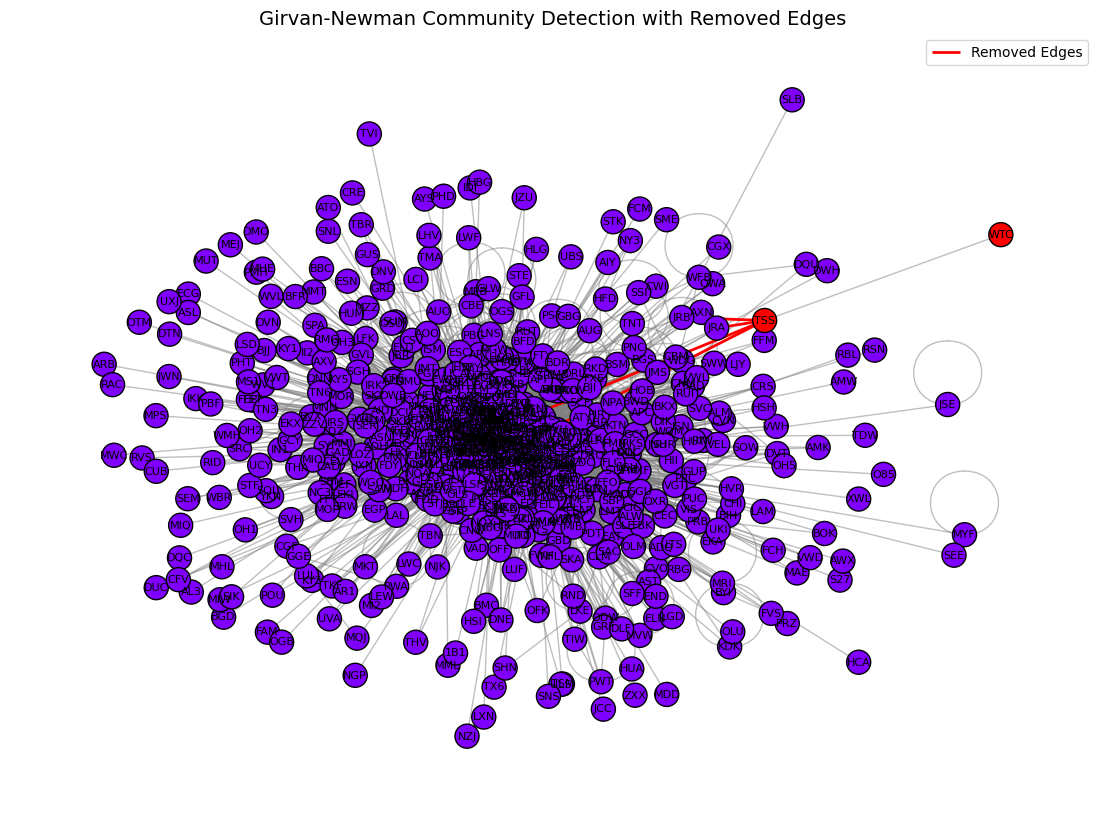

In [119]:
plot_girvan_newman_communities(airport_graph, communities, removed_edges)


In [120]:
modularity_score = calculate_modularity_airport(airport_graph, communities)
modularity_score


8.645282688093535e-05

Result is embarassing, let's try with spectral clustering instead:

In [125]:
k_clusters = 2  # Number of partitions we want
spectral_communities = spectral_clustering(airport_graph, k_clusters)

Sorted Eigenvalues: [5.24958348e-17 3.94728322e-01 4.04087798e-01]
Converged at iteration 2


In [126]:
# Print detected communities
print("\nDetected Communities:")
for i, community in enumerate(communities):
    print(f"Community {i+1}: {community}")



Detected Communities:
Community 1: ['MHK', 'GPT', 'BHM', 'LRD', 'AOH', 'MEM', 'EWN', 'CPS', 'CAE', 'OSH', 'PAH', 'COU', 'GEG', 'ATY', 'MSP', 'CWA', 'CPR', 'GGG', 'CHS', 'CVS', 'HNL', 'YKM', 'GTF', 'BZN', 'MFR', 'MOD', 'MCE', 'RDD', 'FAI', 'FBK', 'FCA', 'EAT', 'BLI', 'TWF', 'DQF', 'GYY', 'MNN', 'DPA', 'HLM', 'GSO', 'RIC', 'GTR', 'EVV', 'BMI', 'TVC', 'MWC', 'COS', 'GCK', 'AGC', 'PIT', 'UCA', 'RDU', 'IAB', 'LFT', 'CRP', 'MIA', 'MCF', 'BGR', 'RKD', 'ALB', 'ART', 'OKC', 'BWG', 'LUK', 'BFD', 'SCE', 'MKE', 'BDR', 'JRB', 'JFK', 'ORL', 'HSV', 'TUS', 'GRF', 'CYS', 'HYS', 'BRL', 'ALO', 'SUS', 'ABY', 'MGM', 'FLO', 'GSP', 'GLH', 'PIB', 'LNK', 'SPI', 'TBN', 'MCI', 'LUL', 'ELP', 'WV1', 'YIP', 'JBR', 'DFW', 'WQM', 'ATL', 'MWA', 'MSN', 'SMF', 'JAN', 'MI2', 'CHA', 'ORH', 'PGD', 'CMH', 'NQA', 'PIA', 'EWR', 'SBY', 'LGA', 'BGM', 'BDL', 'LCH', 'SPS', 'ROW', 'CVN', 'SVC', 'ALM', 'FMN', 'ICT', 'IN1', 'SYR', 'GMU', 'OH3', 'CLT', 'BYH', 'IAH', 'HUM', 'GFK', 'LAR', 'PKB', 'MGW', 'LNS', 'MDT', 'EUG', 'LGU', 'CLL

Same

# 5. Finding and Extracting Communities (Q5)


Airlines can optimize their operations by identifying communities within a flight network. These communities represent groups of airports with strong connections, helping airlines pinpoint high-demand regions for expansion or underserved areas for consolidation. By analyzing these communities, airlines can improve resource allocation, reduce costs, and enhance service quality.



1. In this task, you are asked to analyze the graph and identify the communities based on the flight network provided. For the airline, the primary focus is on the cities, so your communities should reflect the connectivity between cities through the flights that link them.

# Girvan Newman method

##### Pseudo Code for Depth-First Search (DFS) RECURSIVE

Input:

    Graph G = (V, E) as an adjacency list
    Source node s

Output:

    Set of visited nodes
    Previous nodes for path reconstruction

Procedure DFS_Recursive(G, s):

    Initialize:
        visited ← Empty set                  # Tracks visited nodes
        prev ← Empty dictionary              # To reconstruct paths
    
    Function Explore(u):
        Mark u as visited
        For each neighbor v of u:
            If v is not in visited:
                prev[v] ← u                  # Track parent
                Explore(v)                   # Recursive call

    Explore(s)                               # Start DFS from source
    Return visited, prev

##### Pseudo Code for Depth-First Search (DFS) ITERATIVE

Input:

    Graph G = (V, E) as an adjacency list
    Source node s

Output:

    Set of visited nodes
    Previous nodes for path reconstruction

Procedure DFS_Iterative(G, s):

    Initialize:
        visited ← Empty set                 # Tracks visited nodes
        prev ← Empty dictionary             # To reconstruct paths
        Stack S = []                        # LIFO stack
    
    Push s onto S                           # Start DFS from source

    While S is not empty:
        u ← S.pop()                         # Process the most recent node
        
        If u is not in visited:
            Mark u as visited
            For each neighbor v of u:
                If v is not in visited:
                    prev[v] ← u             # Track parent
                    S.push(v)               # Push neighbor onto stack

    Return visited, prev

Time Complexity: $O(V+E)$ for both

##### Psuedo Code for Breadth-First Search (BFS)

Input:

    Graph G = (V, E) as an adjacency list
    Source node s

Output:

    Distance from s to each reachable node
    Previous nodes for path reconstruction

Procedure BFS(G, s):

    Initialize:
        dist[u] ← ∞ for all nodes u ∈ V     # Tentative distances
        dist[s] ← 0                         # Distance to source is 0
        prev[u] ← None for all u ∈ V        # To reconstruct paths
        Queue Q = []                        # FIFO queue
    
    Enqueue s into Q                        # Start from the source node

    While Q is not empty:
        u ← Q.dequeue()                     # Dequeue the front node

        For each neighbor v of u:
            If dist[v] == ∞:                # Unvisited node
                dist[v] ← dist[u] + 1       # Update distance
                prev[v] ← u                 # Track parent
                Q.enqueue(v)                # Enqueue neighbor

    Return dist, prev                     

Time Complexity: $O(V+E)$

##### Pseudo Code for Dijkstra's Algorithm
Input:

    Graph G = (V, E) as an adjacency list
    Edge weights w(u, v) > 0
    Source node s

Output:

    Shortest distances from s to all nodes
    Previous nodes to reconstruct the paths

Procedure Dijkstra(G, s):

    Initialize:
        dist[u] ← ∞ for all nodes u ∈ V     # Tentative distances
        dist[s] ← 0                         # Distance to source is 0
        prev[u] ← None for all u ∈ V        # To reconstruct paths
        PriorityQueue Q = []                # Min-heap: (distance, node)

    Insert (0, s) into Q                    # Start from the source node

    While Q is not empty:
        (current_dist, u) ← Q.pop()         # Node with smallest distance

        For each neighbor v of u:
            weight ← w(u, v)                # Edge weight
            distance ← current_dist + weight
            
            If distance < dist[v]:          # Found a shorter path
                dist[v] ← distance
                prev[v] ← u
                Q.push((distance, v))       # Update priority queue

    Return dist, prev                     


Time Complexity:  $O(V+E)logV)$ using a binary heap.


### Our Implementation of Girvan-Newman
The Girvan-Newman algorithm is a community detection method for graphs that works by progressively removing edges with the highest betweenness centrality. It identifies communities (connected subgraphs) by breaking the graph apart iteratively.

1. Calculate Edge Betweenness Centrality: Betweenness measures how often an edge appears on the shortest paths between nodes.
We can use either:

- BFS: Efficient for unweighted graphs.

- Dijkstra: General-purpose for weighted graphs.

2. Remove the Edge with Highest Betweenness: The edge with the largest centrality score is removed as it is considered a "bridge" between communities.

4. Find Connected Components: After edge removal, the graph is split into components (disconnected subgraphs).
This can be done using either using
- DFS (Iterative)
- DFS (Recursive) methods.
- 
Repeat: recalculating betweenness and removing edges until the desired number of communities is reached or no edges remain.


### Main Source

The notebook TA's provided served as a bible for implementing and testing the algorithm.

Link: https://www.analyticsvidhya.com/blog/2020/04/community-detection-graphs-networks/

(34, 78)

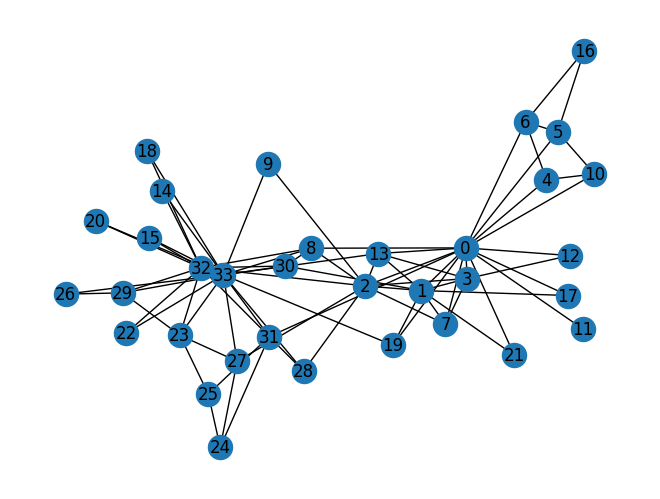

In [19]:
import networkx as nx
G = nx.karate_club_graph()

# visualize the graph

nx.draw(G, with_labels = True)

len(G.nodes), len(G.edges)


In [19]:
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import networkx as nx
import time
from part5_func import *

# Libraries that we need here, the other are in Part5_func



Running Girvan-Newman Algorithm...

[DEBUG] Iteration 0: Calculating betweenness centrality...
[DEBUG] Removed edge: (0, 31)
[DEBUG] Communities: [[0, 1, 2, 3, 7, 12, 13, 33, 8, 30, 32, 14, 15, 18, 20, 22, 23, 25, 24, 27, 31, 28, 29, 26, 9, 19, 17, 21, 4, 6, 5, 10, 16, 11]]

[DEBUG] Iteration 1: Calculating betweenness centrality...
[DEBUG] Removed edge: (0, 2)
[DEBUG] Communities: [[0, 1, 2, 3, 7, 12, 13, 33, 8, 30, 32, 14, 15, 18, 20, 22, 23, 25, 24, 27, 31, 28, 29, 26, 9, 19, 17, 21, 4, 6, 5, 10, 16, 11]]

[DEBUG] Iteration 2: Calculating betweenness centrality...
[DEBUG] Removed edge: (0, 8)
[DEBUG] Communities: [[0, 1, 2, 3, 7, 12, 13, 33, 8, 30, 32, 14, 15, 18, 20, 22, 23, 25, 24, 27, 31, 28, 29, 26, 9, 19, 17, 21, 4, 6, 5, 10, 16, 11]]

[DEBUG] Iteration 3: Calculating betweenness centrality...
[DEBUG] Removed edge: (13, 33)
[DEBUG] Communities: [[0, 1, 2, 3, 7, 12, 13, 8, 30, 32, 14, 33, 9, 15, 18, 19, 20, 23, 25, 24, 27, 31, 28, 29, 26, 22, 17, 21, 4, 6, 5, 10, 16, 11]]

[DEB

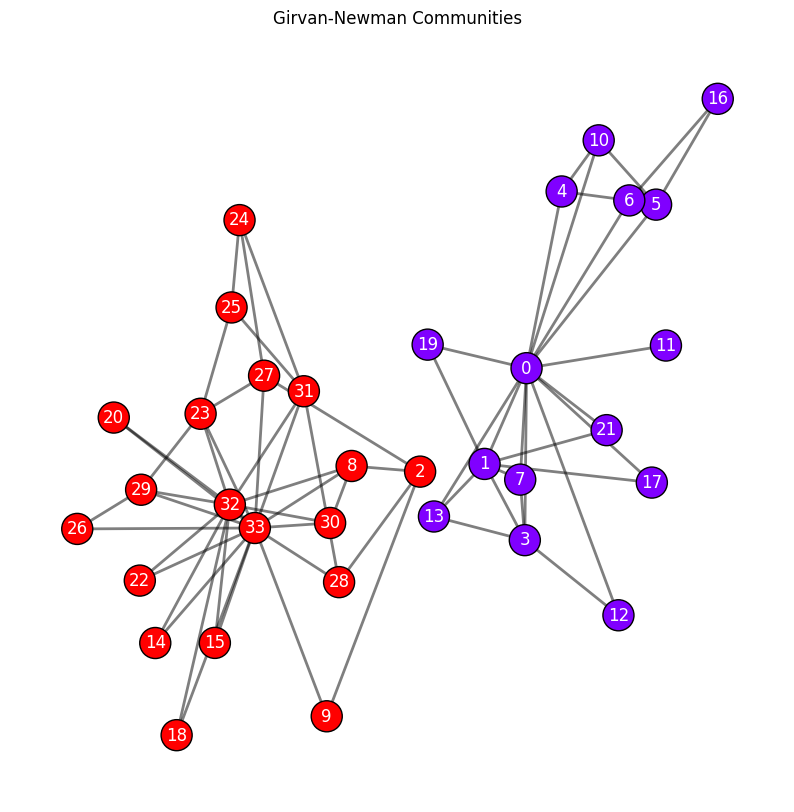

In [22]:
# Choose methods
betweenness_method = "bfs"  # Options: "bfs", "dijkstra"
component_method = "dfs_recursive"  # Options: "dfs_recursive", "dfs_iterative"

print("\nRunning Girvan-Newman Algorithm...")
communities, removed_edges = custom_girvan_newman(G, betweenness_method, component_method)

# Visualize Results
visualize_communities(G, communities, removed_edges)

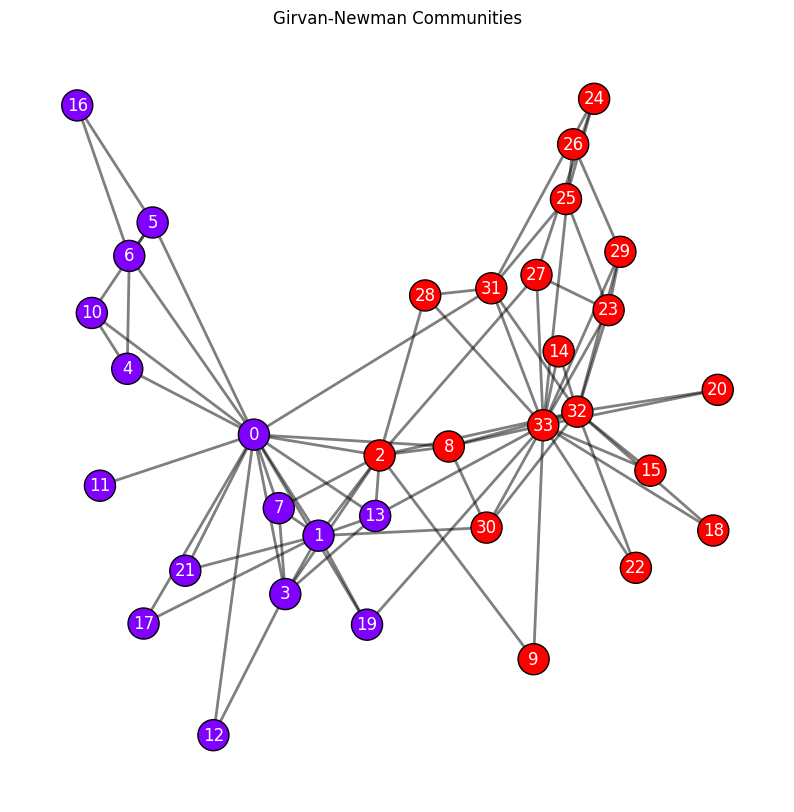

In [23]:
# Visualizing NetworkX implementation
from networkx.algorithms.community import girvan_newman as nx_girvan_newman
comp_gen = nx_girvan_newman(G)
communities = tuple(sorted(c) for c in next(comp_gen)) 
communities = [list(c) for c in communities]

visualize_communities(G, communities)


In [24]:
# --- Test Girvan-Newman Algorithm ---
# --- Run Tests ---
if __name__ == "__main__":
    import networkx as nx

    # Create a test graph
    nx_G = nx.karate_club_graph()
    edges = list(nx_G.edges())
    G = Graph(edges)  # Custom graph

    # Testing different methods
    methods = ["bfs", "dijkstra"]  # Betweenness centrality methods
    component_methods = ["dfs_recursive", "dfs_iterative"]  # Component finding methods

    for betweenness_method in methods:
        for component_method in component_methods:
            test_girvan_newman(G, betweenness_method, component_method)



 ⚠️--- Testing with Custom Method: bfs | Component Method: dfs_recursive ---

[DEBUG] Iteration 0: Calculating betweenness centrality...
[DEBUG] Removed edge: (0, 31)
[DEBUG] Communities: [[0, 1, 2, 32, 33, 8, 30, 9, 13, 3, 7, 12, 14, 15, 18, 19, 20, 22, 23, 25, 24, 27, 31, 28, 29, 26, 17, 21, 4, 10, 5, 16, 6, 11]]

[DEBUG] Iteration 1: Calculating betweenness centrality...
[DEBUG] Removed edge: (0, 2)
[DEBUG] Communities: [[0, 1, 2, 32, 33, 8, 30, 9, 13, 3, 7, 12, 14, 15, 18, 19, 20, 22, 23, 25, 24, 27, 31, 28, 29, 26, 17, 21, 4, 10, 5, 16, 6, 11]]

[DEBUG] Iteration 2: Calculating betweenness centrality...
[DEBUG] Removed edge: (0, 8)
[DEBUG] Communities: [[0, 1, 2, 32, 33, 8, 30, 9, 13, 3, 7, 12, 14, 15, 18, 19, 20, 22, 23, 25, 24, 27, 31, 28, 29, 26, 17, 21, 4, 10, 5, 16, 6, 11]]

[DEBUG] Iteration 3: Calculating betweenness centrality...
[DEBUG] Removed edge: (13, 33)
[DEBUG] Communities: [[0, 1, 2, 32, 33, 8, 30, 9, 14, 15, 18, 19, 20, 22, 23, 25, 24, 27, 31, 28, 29, 26, 3, 7, 1

Faster implementation:

 ⚠️--- Testing with Custom Method: dijkstra | Component Method: dfs_recursive ---

Modularity is the same in any case, specifically the value is: Modularity: 0.35996055226824236


# Optimization Techniques for Community Detection

##### Spectral Clustering for Community Detection

**Input**:

- Graph \( G = (V, E) \) represented as an adjacency matrix.
- Number of clusters \( k \).

**Output**:

- Detected communities.

**Procedure**:

**Compute adjacency and degree matrices**:

    - \( \text{adj\_matrix} \) is the adjacency matrix of \( G \).
    - \( \text{degrees}[i][i] = \sum_j \text{adj\_matrix}[i][j] \) (diagonal degree matrix).

**Calculate the normalized Laplacian**:

    - Compute \( \text{D\_inv\_sqrt}[i][i] = \frac{1}{\sqrt{\text{degrees}[i][i]}} \).
    - Replace \( NaN \) values with \( 0 \) (to handle division by zero).
    - Compute the normalized Laplacian:
      \( L = I - \text{D\_inv\_sqrt} \times \text{adj\_matrix} \times \text{D\_inv\_sqrt} \).

**Perform eigenvalue decomposition**:

    - Compute eigenvalues and eigenvectors of \( L \).
    - Sort eigenvalues in ascending order.
    - Select eigenvectors corresponding to the \( k \) smallest non-trivial eigenvalues.

**Normalize the eigenvectors**:

    - Normalize each row of the eigenvector matrix.

**Apply K-means clustering**:

    - Use the \( k \)-dimensional eigenvector representation of nodes as input to K-means clustering.
    - Assign each node to a cluster based on the K-means result.

**Group nodes into communities**:

    - For each cluster, group the nodes that belong to it.

**Return**:

    - Detected communities.


In [27]:
import networkx as nx
# --- Test Spectral Clustering Algorithm ---
# Convert NetworkX karate club graph to edge list
nx_G = nx.karate_club_graph()
edges = list(nx_G.edges()) # Extract unweighted edges
G = Graph(edges) 

print("\n--- Spectral Clustering ---")
spectral_communities = spectral_clustering(G, k=2)
print("Spectral Communities:", spectral_communities)
adj_matrix, nodes = G.adjacency_matrix()  # Extract the adjacency matrix
print("Modularity:", calculate_modularity(adj_matrix, spectral_communities))



--- Spectral Clustering ---
Sorted Eigenvalues: [4.46085674e-16 1.32272329e-01 2.87048985e-01]
Converged at iteration 1
Spectral Communities: [[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21], [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]
Modularity: 0.3714661406969083


##### Louvain Method for Community Detection

**Input**:

- Graph \( G = (V, E) \) represented as an adjacency matrix.
- Maximum number of iterations \( \text{max\_iter} \).

**Output**:

- Detected communities.
- Final modularity score.

**Procedure**:

**Initialize**:

    - Let \( n \) be the number of nodes in \( G \).
    - Compute \( \text{degrees}[i] = \sum_{j} G[i][j] \) for all nodes \( i \).
    - Set \( \text{inv\_m} = \frac{1}{\sum \text{degrees}} \) for modularity normalization.
    - Assign each node to its own community:
      \( \text{communities}[i] = i \).

**Define modularity gain**:

    - \( k_i = \text{degrees}[i] \).
    - Let \( \text{delta\_q} = 0 \).
    - For each neighbor \( j \) of node \( i \):
        - If \( j \) belongs to \( \text{target\_comm} \), increment \( \text{delta\_q} \) by \( G[i][j] \).
        - If \( j \) belongs to \( \text{curr\_comm} \), decrement \( \text{delta\_q} \) by \( G[i][j] \).
    - Compute the degree sums for the target and current communities:
        - \( \text{sum\_target} = \sum \text{degrees}[k] \, \forall k \in \text{target\_comm} \).
        - \( \text{sum\_curr} = \sum \text{degrees}[k] \, \forall k \in \text{curr\_comm} \).
    - Adjust \( \text{delta\_q} \):
        - \( \text{delta\_q} -= k_i \times (\text{sum\_target} - k_i) \times \text{inv\_m} \).
        - \( \text{delta\_q} += k_i \times (\text{sum\_curr} - k_i) \times \text{inv\_m} \).

**Iteratively refine communities**:

    - For \( \text{max\_iter} \) iterations:
        - Set \( \text{moved} = \text{False} \).
        - For each node \( i \):
            - Evaluate the modularity gain for moving \( i \) to each neighboring community.
            - Move \( i \) to the community with the highest modularity gain if it improves the modularity.
            - Update \( \text{moved} \) if any node was reassigned.
        - Terminate if no nodes were moved.

**Extract communities**:

    - Group nodes by their final community assignments.

**Return**:

    - Detected communities.
    - Final modularity score.


In [104]:
# --- Test Louvain Method ---
# Example usage
if __name__ == "__main__":
    # Generate test graph
    nx_G = nx.karate_club_graph()
    adj_matrix = nx.to_numpy_array(nx_G)

    print("\n--- Louvain Method with NumPy ---")
    communities = louvain_cluster(adj_matrix, max_iter=10)
    print("\nDetected Communities:", communities)

modularity = calculate_modularity(adj_matrix, communities)
print(f"Modularity: {modularity:.6f}")


--- Louvain Method with NumPy ---

Detected Communities: [[0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21], [4, 10], [5, 6, 16], [8, 9, 14, 15, 18, 20, 22, 30, 32, 33], [23, 24, 25, 27, 28, 31], [26, 29]]
Modularity: 0.418677


#### **1. Lambiotte Coefficient (Node Importance)**
The **Lambiotte Coefficient** measures how central a node is to its community. It evaluates the proportion of connections a node has within its assigned community relative to all possible connections.

- **Formula**:
  
  $L(n) = \frac{\text{Internal Degree of Node } n}{\text{Degree of Node } n}$

  Where:
  - **Internal Degree**: Number of edges the node shares with nodes in its own community.
  - **Degree**: Total number of edges connected to the node.

- **Interpretation**:
  - Values close to **1.0**: The node is strongly integrated into its community and most of its connections are internal.
  - Lower values (e.g., 0.5): The node has significant connections outside its community, making it less central.

---

#### **2. Clauset's Parameter (Community Strength)**
The **Clauset's Parameter** measures the cohesion or density of a community relative to the entire graph. It evaluates how well a community is connected internally versus its connections to other communities.

- **Formula**:
  
  $C(C_i) = \frac{\text{Internal Edges in } C_i}{\text{Total Edges Involving Nodes in } C_i}$
  
  
  Where:
  - **Internal Edges**: Edges within the community.
  - **Total Edges**: All edges involving nodes in the community, including external edges.

- **Interpretation**:
  - Values close to **1.0**: The community is highly cohesive, with most of its edges being internal.
  - Lower values: The community has weaker internal cohesion, with many external connections.


In [30]:
#!pip uninstall community
#!pip install python-louvain
#!pip install tabulate

In [31]:
import networkx as nx

import time

# --- Testing Custom vs Pre-Implemented ---
if __name__ == "__main__":
    # Test Graph
    nx_G = nx.karate_club_graph()
    adj_matrix = nx.to_numpy_array(nx_G)

    # --- Custom Spectral Clustering ---
    print("\n--- Custom Spectral Clustering ---")
    start_time = time.time()
    custom_communities = spectral_clustering(G, k=2)
    end_time = time.time()
    custom_time = end_time - start_time
    print(f"⏱️ Custom Spectral Time: {custom_time:.6f} seconds")
    print("Custom Spectral Communities:", custom_communities)
    adj_matrix_spectral, nodes = G.adjacency_matrix()
    custom_modularity = calculate_modularity(adj_matrix_spectral, custom_communities)
    print(f"Custom Spectral Modularity: {custom_modularity:.6f}")

    # --- Pre-Implemented Spectral Clustering ---
    print("\n--- Pre-Implemented Spectral Clustering ---")
    start_time = time.time()
    spectral_communities = pre_implemented_spectral(nx_G, k=2)
    end_time = time.time()
    custom_time = end_time - start_time
    print(f"⏱️ Pre-Implemented Spectral Time: {custom_time:.6f} seconds")

    print("Pre-Implemented Spectral Communities:", spectral_communities)
    pre_modularity = calculate_modularity(adj_matrix_spectral, spectral_communities)
    print(f"Pre-Implemented Spectral Modularity: {pre_modularity:.6f}")

    # --- Run Comparisons ---
    print("\n--- Comparison Results ---")
    compare_methods(custom_communities, spectral_communities, "Spectral Clustering")

    # --- Custom Louvain ---
    print("\n--- Custom Louvain Method ---")
    start_time = time.time()
    edges_louvain = [(u, v, 1) for u, v in nx_G.edges()]
    end_time = time.time()
    custom_time = end_time - start_time
    print(f"⏱️ Custom Louvain Time: {custom_time:.10f} seconds")
    custom_louvain = louvain_cluster(adj_matrix, max_iter=15)
    print("Custom Louvain Communities:", custom_louvain)
    custom_modularity = calculate_modularity(adj_matrix, custom_louvain)
    print(f"Custom Louvain Modularity: {custom_modularity:.6f}")
    
    # --- Pre-Implemented Louvain ---
    print("\n--- Pre-Implemented Louvain Method ---")
    start_time = time.time()
    pre_louvain = pre_louvain_method(nx_G)
    end_time = time.time()
    custom_time = end_time - start_time
    print(f"⏱️ Pre-Implemented Louvain Time: {custom_time:.10f} seconds")
    print("Pre-Implemented Louvain Communities:", pre_louvain)
    pre_modularity = calculate_modularity(adj_matrix, pre_louvain)
    print(f"Pre-Implemented Louvain Modularity: {pre_modularity:.6f}")

    # --- Run Comparisons ---
    print("\n--- Comparison Results ---")
    compare_methods(custom_louvain, pre_louvain, "Louvain Clustering")
    # Compare Communities
    compare_communities_overlap(custom_louvain, pre_louvain, "Louvain Clustering")
    evaluate_community_metrics(adj_matrix, custom_communities, "Custom Louvain Clustering")



--- Custom Spectral Clustering ---
Sorted Eigenvalues: [4.46085674e-16 1.32272329e-01 2.87048985e-01]
Converged at iteration 1
⏱️ Custom Spectral Time: 0.002624 seconds
Custom Spectral Communities: [[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21], [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]
Custom Spectral Modularity: 0.371466

--- Pre-Implemented Spectral Clustering ---
⏱️ Pre-Implemented Spectral Time: 0.009348 seconds
Pre-Implemented Spectral Communities: [[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21], [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]
Pre-Implemented Spectral Modularity: 0.371466

--- Comparison Results ---

--- Comparing Spectral Clustering ---
Custom Communities: [[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21], [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]
Pre-Implemented Communities: [[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21], [8, 9, 14, 15, 1

Spectral Clustering is 15 times faster, results are the same

The Custom method aligns well with the pre-implemented approach for major communities, though it sometimes splits larger communities into smaller subsets. Its strenght btw is its computational efficency: it runs a lot faster than the pre-implemented function, but the gain in computational resources we'll be seen more clearly on a larger dataset

### Let's see how it works on the real Dataset

In [3]:
import pandas as pd
df = pd.read_csv("USA_AirportDf_Nans_filled.csv") # Input from Yara's last work
df.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,41.990311,-93.622154
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


In [252]:
df.columns

Index(['Origin_airport', 'Destination_airport', 'Origin_city',
       'Destination_city', 'Passengers', 'Seats', 'Flights', 'Distance',
       'Fly_date', 'Origin_population', 'Destination_population',
       'Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat',
       'Dest_airport_long'],
      dtype='object')

Check to confirm every coordinates was correct: Motivation at the end

In [240]:
import pandas as pd

# Starting boundary points
# https://www.quora.com/What-is-the-longitude-and-latitude-of-a-bounding-box-around-the-continental-United-States#:~:text=What%20are%20the%20latitude%20and,N%20(Top%20to%20bottom).

# This value were tuned until the map looked good
US_LAT_MIN = 18.7763  # Hawaii's southernmost point
US_LAT_MAX = 71.5388  # Alaska's northernmost point
US_LONG_MIN = -179.148909  # Alaska's westernmost point
US_LONG_MAX = -66.93457  # Maine's easternmost point

outside_us = df[
    (df["Org_airport_lat"] < US_LAT_MIN) | (df["Org_airport_lat"] > US_LAT_MAX) |
    (df["Org_airport_long"] < US_LONG_MIN) | (df["Org_airport_long"] > US_LONG_MAX) 
    ]


print("Airports outside the US:")
print(outside_us)


Airports outside the US:
Empty DataFrame
Columns: [Origin_airport, Destination_airport, Origin_city, Destination_city, Passengers, Seats, Flights, Distance, Fly_date, Origin_population, Destination_population, Org_airport_lat, Org_airport_long, Dest_airport_lat, Dest_airport_long]
Index: []


In [197]:
world_map = folium.Map(location=[37, -95], zoom_start=4)

# Add markers for airports outside the US
for _, row in outside_us.iterrows():
    folium.Marker(
        location=[row["Org_airport_lat"], row["Org_airport_long"]],
        icon=folium.Icon(color="red")
    ).add_to(world_map)

# Add US boundary rectangle
bounds = [
    [US_LAT_MIN, US_LONG_MIN],
    [US_LAT_MIN, US_LONG_MAX],
    [US_LAT_MAX, US_LONG_MAX],
    [US_LAT_MAX, US_LONG_MIN],
    [US_LAT_MIN, US_LONG_MIN]
]
folium.Polygon(bounds, color="blue", fill=True, fill_opacity=0.2).add_to(world_map)

# Save and show the map
world_map.save("wrong_coordinates.html")

#world_map


Below the map that represent the actual borders of US

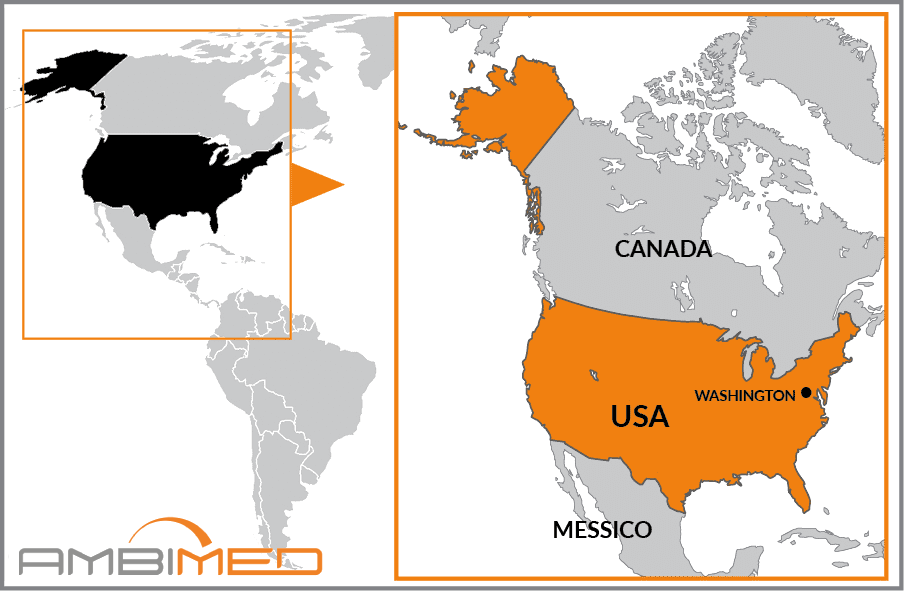

I found some wrong coordinates, in reality the data bugged with Kaggle probably (Since I was working there I pushed Yara's file as Kaggle Dataset, maybe that's where it bugged?). Btw I removed all the part regarding manual data cleaning and merging cause it was useless :) :) Lovely Friday.

But i want to leave this plot as explanation since I didn't know either the actual borders of America, and the info will come usefull later when we'll connect the cities.

### Experimenting on Real Dataset

In [219]:
# Create a graph from the dataset
city_graph = df_to_adjacency_list(df)

In [220]:
print_graph(city_graph, sample_size=1)


Adjacency List Sample (First 1 Nodes):
--------------------------------------------------
Manhattan, KS: ['Philadelphia, PA', 'Dallas, TX', 'Omaha, NE', 'Salt Lake City, UT', 'Great Bend, KS', 'Colorado Springs, CO', 'Lubbock, TX', 'Baltimore, MD', 'Oklahoma City, OK', 'Tulsa, OK', 'Lincoln, NE', 'Waco, TX', 'Cedar Rapids, IA', 'Orlando, FL', 'Waterloo, IA', 'Albuquerque, NM', 'Tucson, AZ', 'Spokane, WA', 'Kansas City, MO', 'South Bend, IN', 'Fresno, CA', 'Indianapolis, IN', 'Jacksonville, FL', 'Little Rock, AR', 'Pittsfield, MA', 'Des Moines, IA', 'Green Bay, WI', 'Kearney, NE', 'Houston, TX', 'New Orleans, LA', 'Garden City, KS', 'Austin, TX', 'Nashville, TN', 'Salina, KS', 'Hattiesburg, MS', 'Bozeman, MT', 'Columbus, OH', 'Lafayette, LA', 'Bloomington, IL', 'Montgomery, AL', 'Hartford, CT', 'Cleveland, OH', 'Wichita, KS', 'St. Louis, MO', 'Stillwater, OK', 'Savannah, GA', 'Rochester, NY', 'Madison, WI', 'Columbia, SC', 'Terre Haute, IN', 'Champaign, IL', 'Hays, KS', 'Akron, OH', 'Li

In [211]:
edges = sum(len(neighbors) for neighbors in city_graph.values()) // 2  
nodes = len(city_graph)
density = (2 * edges) / (nodes * (nodes - 1)) if nodes > 1 else 0  
print(f"Graph Density: {density:.4f}")

Graph Density: 0.1178


Graph density of 0.1178 indicates that the graph is relatively sparse, with only about 11.8% of the possible edges between nodes present. Sparse graphs can pose challenges for community detection algorithms, in particular the one like Girvan-Newman, which rely on edge removal to split the graph into meaningful communities.

Challenges:
- Sparse graphs often lack sufficient edge redundancy to support stable community splits, leading to fragmented communities and limited modularity improvement.

- If edges are distributed without strong clusters, detecting clear community boundaries becomes harder.

- Modularity favors dense, well-connected communities, but sparse graphs inherently lack such structures.

### Complexity of the Girvan–Newman algorithm

- Complexity: $O(N*E)$ This is done for all edges in the graph.
- Removing the edge with the highest betweenness: This operation occurs $E$ times.

Total complexity is approximately: $O(E⋅(N⋅E))=O(N⋅E^2)$

In [13]:
N = 563   # Number of nodes
E = 37262   # Number of edges

# Complexity calculation
estimated_operations = N * (E ** 2)
estimated_operations

781701090572

In [14]:
# Estimate how many operation per second my CPU can do
n = 10**7
ops_per_second = operation_test(n)
print(f"Approximate operations per second: {ops_per_second:.2f}")


Approximate operations per second: 21665688.66


In [15]:
estimated_time_seconds = estimated_operations / ops_per_second
estimated_time_hours = estimated_time_seconds / 3600

estimated_time_hours

10.022261243794668

I did this test cause i wanted to try the algorithms also on the main dataset but I didn't expected it would require so much time. That's why we are just gonna apply our efficient implementation of Louvain method

### Implementation of Louvain method on the Main Dataset

In [221]:
# Adding weights allow us to give more importance to most trafficated airports, this will provide us more meaningfull results
adj_matrix, city_to_idx = df_to_adjacency_matrix(df, weight_col="Passengers")

In [222]:
import time

# Apply Louvain clustering 
print("\n--- Louvain Method with NumPy ---")
start_time = time.time()  # Start timer
communities = louvain_cluster(adj_matrix, max_iter=50)
end_time = time.time()  # End timer

# Print debug information and time taken
print("DEBUG: Type of community_labels:", type(communities))
print("DEBUG: Example of community_labels:", communities[:10])
print(f"DEBUG: Time taken for Louvain clustering: {end_time - start_time:.4f} seconds")


--- Louvain Method with NumPy ---
DEBUG: Type of community_labels: <class 'list'>
DEBUG: Example of community_labels: [[0, 45, 53, 56, 60, 61, 69, 70, 73, 79, 80, 81, 82, 83, 84, 86, 88, 89, 90, 91, 92, 95, 96, 99, 100, 102, 104, 106, 110, 113, 114, 116, 119, 121, 122, 123, 125, 129, 131, 132, 137, 139, 144, 145, 146, 147, 151, 152, 154, 176, 184, 209, 222, 227, 231, 237, 244, 248, 250, 251, 252, 259, 264, 282, 284, 286, 288, 295, 296, 298, 299, 302, 304, 305, 316, 317, 332, 356, 358, 361, 363, 368, 371, 373, 378, 386, 392, 394, 403, 418, 422, 425, 439, 440, 446, 451, 457, 463, 473, 482, 506, 549, 562], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 39, 41, 43, 46, 48, 49, 50, 51, 54, 58, 63, 65, 66, 68, 72, 74, 85, 87, 97, 101, 103, 109, 111, 115, 118, 128, 130, 133, 143, 148, 150, 155, 158, 160, 162, 225, 247, 249, 257, 261, 262, 269, 275, 277, 278, 294, 300, 301, 312, 313, 314, 315, 339, 342, 351, 352, 353

In [223]:
readable_communities = convert_communities_to_readable(communities)
print("readable communities:", readable_communities)

modularity = calculate_modularity(adj_matrix, readable_communities)
print("Modularity:", modularity)


readable communities: [[0, 45, 53, 56, 60, 61, 69, 70, 73, 79, 80, 81, 82, 83, 84, 86, 88, 89, 90, 91, 92, 95, 96, 99, 100, 102, 104, 106, 110, 113, 114, 116, 119, 121, 122, 123, 125, 129, 131, 132, 137, 139, 144, 145, 146, 147, 151, 152, 154, 176, 184, 209, 222, 227, 231, 237, 244, 248, 250, 251, 252, 259, 264, 282, 284, 286, 288, 295, 296, 298, 299, 302, 304, 305, 316, 317, 332, 356, 358, 361, 363, 368, 371, 373, 378, 386, 392, 394, 403, 418, 422, 425, 439, 440, 446, 451, 457, 463, 473, 482, 506, 549, 562], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 39, 41, 43, 46, 48, 49, 50, 51, 54, 58, 63, 65, 66, 68, 72, 74, 85, 87, 97, 101, 103, 109, 111, 115, 118, 128, 130, 133, 143, 148, 150, 155, 158, 160, 162, 225, 247, 249, 257, 261, 262, 269, 275, 277, 278, 294, 300, 301, 312, 313, 314, 315, 339, 342, 351, 352, 353, 354, 359, 372, 380, 397, 399, 400, 401, 402, 404, 405, 421, 424, 452, 481, 484, 486, 487, 490, 

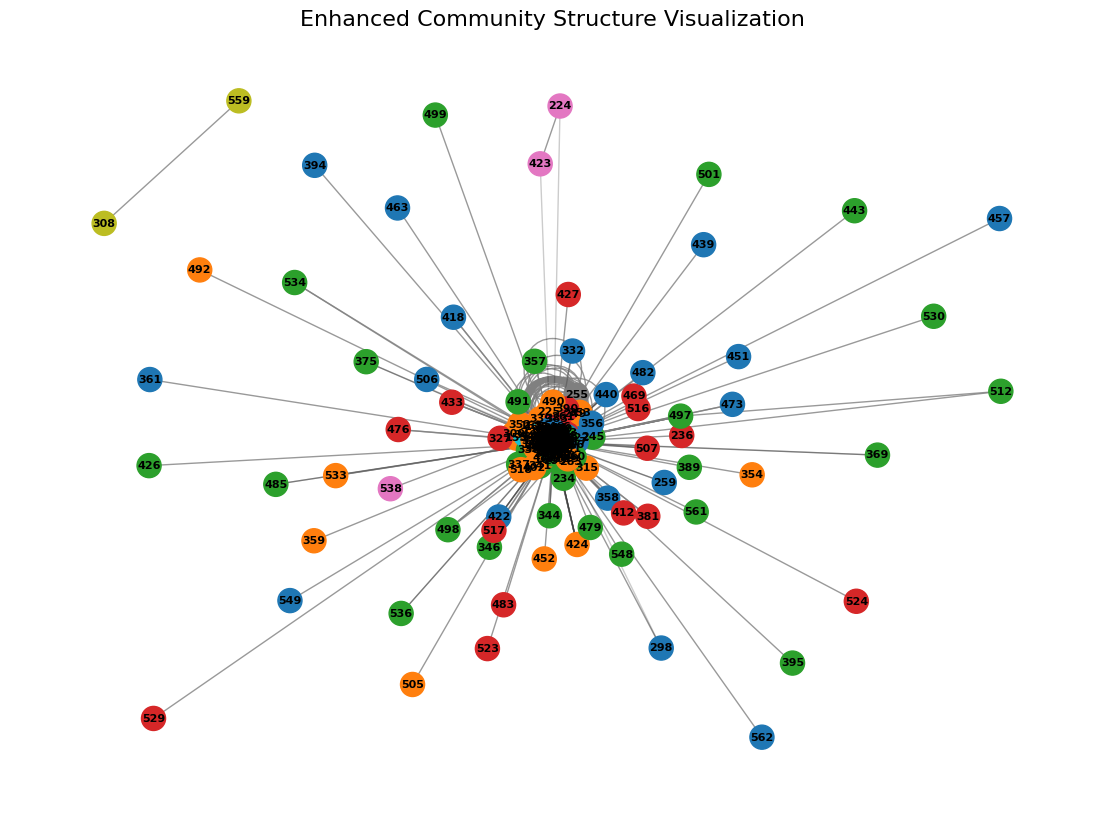

In [224]:
plot_communities_air(adj_matrix, readable_communities)

In [267]:
colored_connections_map = plot_communities_with_colored_connections(df, adj_matrix, readable_communities, city_to_idx)
colored_connections_map.save("connections_map.html")  # Save the map to an HTML file
#colored_connections_map  # Display the map in Jupyter/Colab


### I was almost forgetting to answer to question 5.2

2. The function takes the following inputs:

- Flight network
- A city name *c1*
- A city name *c2*
  
3. The function outputs:

- The total number of communities and the cities that belong to each community
- Visualize the graph highlighting the communities within the network (each community with different color)
- If city c1 and c2 belong to the same community or not


In [ ]:
cities = list(set(df["Origin_city"]).union(df["Destination_city"]))
analyze_flight_network(adj_matrix, cities, "Eugene, OR", "Bend, OR")


City Eugene, OR and City Bend, OR belong to the same community: True



In [49]:
# Let's stake a small state that is far away from Oregon to ensure everything works correctly
analyze_flight_network(adj_matrix, cities, "Eugene, OR", "Fort Leonard Wood, MO")


City Eugene, OR and City Fort Leonard Wood, MO belong to the same community: False



### Ask LLM

Some consideration:
- He knew I was working with Louvain Method
- First time I gave the prompt it suggested me to use Girvan-Newman Algorithm but since I already implemented it I asked for an other one
- I asked to use the same Nx graph we were using as a test to compare results with all the other algorithms we tried

##### Alternative Algorithm: Label Propagation Algorithm (LPA)
The Label Propagation Algorithm uses a semi-supervised learning approach where nodes are labeled based on the majority of their neighbors' labels. Communities naturally emerge as nodes adopt similar labels to those they are closely connected with.

Steps to Implement the Label Propagation Algorithm:

- Initialize Labels: Assign a unique label to each node in the graph.

- Iterative Update: For each node, update its label to the one that is most common among its neighbors. Ties can be broken randomly.

- Convergence: Repeat until no labels change or a maximum number of iterations is reached.

- Extract Communities: Nodes with the same label are grouped into the same community.

Advantages of Label Propagation Algorithm:

- Scalability: Highly efficient and suitable for large graphs.

- Flexibility: Works well without requiring prior knowledge about the number of communities.

- Simplicity: Straightforward implementation without heavy computational overhead.


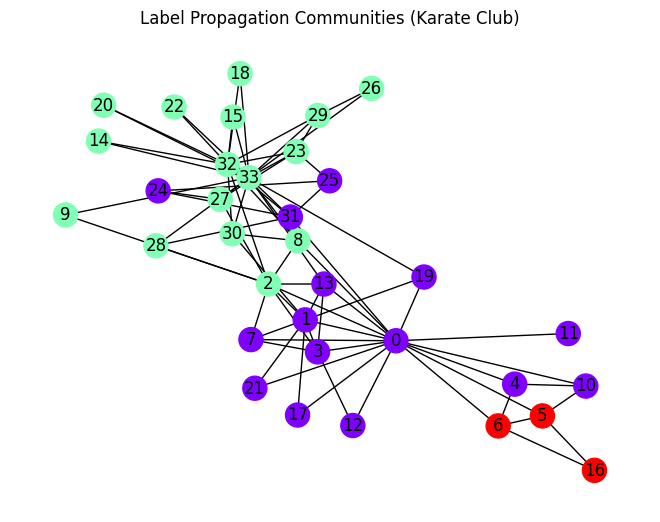

0.30948632896684836

In [35]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import label_propagation_communities

# Load the Karate Club graph
graph = nx.karate_club_graph()

# Detect communities using Label Propagation Algorithm
lpa_communities = list(label_propagation_communities(graph))

# Visualize the communities
def visualize_communities(graph, communities, title):
    # Assign colors based on communities
    node_colors = {}
    for i, community in enumerate(communities):
        for node in community:
            node_colors[node] = i
    colors = [node_colors[node] for node in graph.nodes()]
    
    # Layout and drawing
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, node_color=colors, with_labels=True, cmap=plt.cm.rainbow)
    plt.title(title)
    plt.show()

# Visualize the detected communities
visualize_communities(graph, lpa_communities, "Label Propagation Communities (Karate Club)")
calculate_modularity(nx.to_numpy_array(graph), lpa_communities) # i added modularity check


##### Comment

I tried LPA during my tests in first phase cause it was recommended by the link of the article TA's shared for Q5 as Machine Learning approach. Nonethless it's pretty fast, it resulted in lower accurancy, in fact we have the lowest Modularity score recorded.

To make it a fair comparison I am gonna compare it also on the Airport Dataset

Time taken for Label Propagation clustering on adjacency matrix: 0.0240 seconds


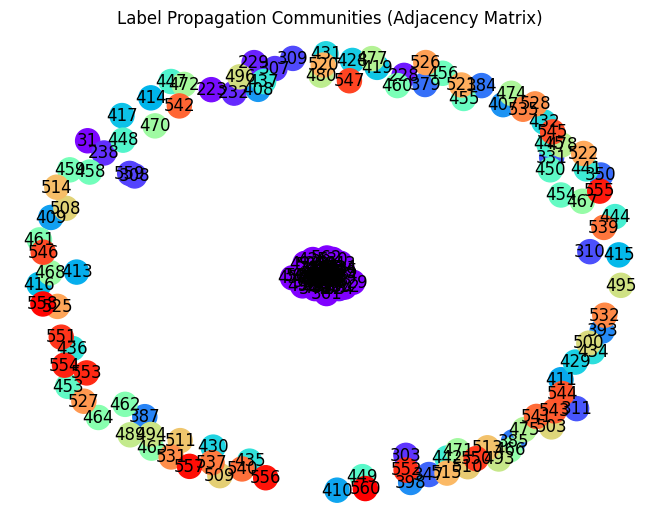

In [51]:
import numpy as np
import networkx as nx
import time
from networkx.algorithms.community import label_propagation_communities

graph_from_adj_matrix = nx.from_numpy_array(adj_matrix) # Convert the adjacency matrix to a NetworkX graph

start_time = time.time()

lpa_communities_from_adj_matrix = list(label_propagation_communities(graph_from_adj_matrix))

end_time = time.time()

print(f"Time taken for Label Propagation clustering on adjacency matrix: {end_time - start_time:.4f} seconds")

visualize_communities(graph_from_adj_matrix, lpa_communities_from_adj_matrix, "Label Propagation Communities (Adjacency Matrix)")


In [52]:
analyze_communities(graph_from_adj_matrix, lpa_communities_from_adj_matrix)

=== Community Analysis ===
Total Communities Detected: 117

Community 1:
  Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 2

##### Final comment

Only 1 big community was founded and more than 100 communities with only one node. It is enough to say LPA performed really badly in our scenario, at least it was fast to run!